In [24]:
from IPython.core.display import display

import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import normalize as nm

import lightgbm as lgb
from pyfm import pylibfm

import matplotlib as mpl
font = {"family":"Noto Sans CJK JP"}
mpl.rc('font', **font)

In [25]:
# versionの確認
%load_ext watermark
%watermark -u -d -v -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
json        2.0.9
autopep8    1.3.5
re          2.2.1
numpy       1.15.4
pandas      0.23.4
seaborn     0.8.1
lightgbm    2.1.2
matplotlib  2.1.2
last updated: 2018-11-23 

CPython 3.6.7
IPython 7.1.1


In [26]:
ex_total_df = pd.read_csv("../ext_source/ex_total.csv")
stadium_df = pd.read_csv("../input/stadium_capacity_mapping.csv")
ex_stadium_df = pd.read_csv("../ext_source/ex_stadium_capacity_mapping.csv")

# まずは両者の違いを確認する

In [27]:
# 全角、半角の違い、名称の変化が原因に考えられる
print(set(stadium_df.stadium.unique().tolist()) - set(ex_stadium_df.stadium.unique().tolist()))
print("-"*90)
print(set(ex_stadium_df.stadium.unique().tolist()) - set(stadium_df.stadium.unique().tolist()))

{'チュウブYAJINスタジアム', 'NDソフトスタジアム山形', '浦和駒場スタジアム', '埼玉スタジアム2002', '大阪長居第2陸上競技場', 'あきぎんスタジアム', 'Pikaraスタジアム', 'ShonanBMWスタジアム平塚', '白波スタジアム', 'いわぎんスタジアム', '長野Uスタジアム', '会津総合運動公園あいづ陸上競技場', 'とうほう・みんなのスタジアム', 'タピック県総ひやごんスタジアム', 'NACK5スタジアム大宮', 'ミクニワールドスタジアム北九州', '相模原ギオンスタジアム', '藤枝総合運動公園サッカー場', '秋田市八橋運動公園陸上競技場', '沖縄市陸上競技場', 'IAIスタジアム日本平', 'ヤマハスタジアム(磐田)', 'ひとめぼれスタジアム宮城', '愛鷹広域公園多目的競技場'}
------------------------------------------------------------------------------------------
{'京都市西京極総合運動公園陸上競技場', '長崎県立総合運動公園陸上競技場', '大阪長居第２陸上競技場', '都市公園富士北麓公園陸上競技場', '鳥取市営サッカー場バードスタジアム', '大分市営陸上競技場', 'ｋａｎｋｏスタジアム', '長野市営長野運動公園総合運動場', '福山市竹ケ端運動公園陸上競技場', '長野運動公園総合運動場', '岡山県陸上競技場桃太郎スタジアム', 'うまかな・よかなスタジアム', '静岡県営草薙陸上競技場', '江戸川区陸上競技場', 'ＮＡＣＫ５スタジアム大宮', '愛媛県総合運動公園陸上競技場', '市原臨海競技場', 'ＩＡＩスタジアム日本平', 'ひたちなか市総合運動公園陸上競技場', '室蘭市入江運動公園陸上競技場', '大分スポーツ公園総合競技場', 'サンプロアルウィン', '新潟市陸上競技場', '維新百年記念公園陸上競技場', '等々力緑地運動公園陸上競技場', '瑞穂公園陸上競技場', '国立西が丘サッカー場', '東京スタジアム', '草薙総合運動公園陸上競技場', '沖縄県総合運動公園陸上競技場', '足利市総合運動公園陸上競技場', '千代台公園陸上競技場', '函館市千代台公

# 全角→半角へ
まずは全角半角で統一する

In [28]:
# こっちは今回は使わない(大規模なデータを処理する際はこっちを使ってuniqueなものだけ前処理しておくと早い)
def make_zen2han_dic(iterable):
    zen = list("ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺ" +
               "ａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ" +
               "０１２３４５６７８９，、．。（）＿−　")
    han = list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789,,..()_- ")
    z2h = {}
    pattern = "|".join(zen)
    for it in iterable:
        if re.search(pattern, it) is None:
            continue
        target = it*1
        for z, h in zip(zen, han):
            target = target.replace(z, h)
        z2h[it] = target
    return z2h

def make_zen2han_translater():
    zen = list("ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺ" +
               "ａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ" +
               "０１２３４５６７８９，、．。（）＿　")
    han = list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789,,..()_ ")
    zen2han = str.maketrans({z:h for z, h in zip(zen, han)})

    def translate_zen2han(x):
        return x.translate(zen2han)
    
    return translate_zen2han

translater = make_zen2han_translater()

stadium_df["stadium"] = stadium_df["stadium"].apply(translater)
ex_stadium_df["stadium"] = ex_stadium_df["stadium"].apply(translater)

In [29]:
# これと元データを結びつけるのはやや厄介
remains = set(stadium_df.stadium.unique().tolist()) - set(ex_stadium_df.stadium.unique().tolist())
remains

{'あきぎんスタジアム',
 'いわぎんスタジアム',
 'とうほう・みんなのスタジアム',
 'ひとめぼれスタジアム宮城',
 'タピック県総ひやごんスタジアム',
 'チュウブYAJINスタジアム',
 'ミクニワールドスタジアム北九州',
 '会津総合運動公園あいづ陸上競技場',
 '愛鷹広域公園多目的競技場',
 '沖縄市陸上競技場',
 '浦和駒場スタジアム',
 '白波スタジアム',
 '相模原ギオンスタジアム',
 '秋田市八橋運動公園陸上競技場',
 '藤枝総合運動公園サッカー場',
 '長野Uスタジアム'}

In [30]:
# 同じ観客動員数のスタジアムから探す
# 15000人以下のスタジアムはJ1だと基本は使われないので雑でよい
ix_dict = {v: i for i, v in enumerate(stadium_df["stadium"].values)}
for remain in remains:
    ix = ix_dict[remain]
    capacity = stadium_df.loc[ix, "capacity"]
    
    print(remain)
    display(pd.concat([stadium_df.query("capacity == {}".format(capacity)),
                       ex_stadium_df.query("capacity == {}".format(capacity))]))

name_pairs = (["鹿児島県立鴨池陸上競技場", "白波スタジアム"],
              ["宮城スタジアム", "ひとめぼれスタジアム宮城"],
              ["浦和駒場スタジアム", "さいたま市浦和駒場スタジアム"],
              ["浦和市駒場スタジアム", "さいたま市浦和駒場スタジアム"])

相模原ギオンスタジアム


,stadium,capacity
92,相模原ギオンスタジアム,6291.0


会津総合運動公園あいづ陸上競技場


,stadium,capacity
88,会津総合運動公園あいづ陸上競技場,7290.0


あきぎんスタジアム


,stadium,capacity
96,あきぎんスタジアム,5017.0


白波スタジアム


,stadium,capacity
80,鹿児島県立鴨池陸上競技場,12584.0
81,白波スタジアム,12584.0


チュウブYAJINスタジアム


,stadium,capacity
90,チュウブYAJINスタジアム,7044.0


いわぎんスタジアム


,stadium,capacity
97,いわぎんスタジアム,4938.0


秋田市八橋運動公園陸上競技場


,stadium,capacity
47,秋田市八橋運動公園陸上競技場,20125.0


とうほう・みんなのスタジアム


,stadium,capacity
91,とうほう・みんなのスタジアム,6464.0


藤枝総合運動公園サッカー場


,stadium,capacity
95,藤枝総合運動公園サッカー場,5056.0


沖縄市陸上競技場


,stadium,capacity
79,沖縄市陸上競技場,13400.0


浦和駒場スタジアム


,stadium,capacity
32,浦和駒場スタジアム,21500.0
33,さいたま市浦和駒場スタジアム,21500.0
6,浦和市駒場スタジアム,21500.0
63,さいたま市浦和駒場スタジアム,21500.0


長野Uスタジアム


,stadium,capacity
64,長野Uスタジアム,15515.0


タピック県総ひやごんスタジアム


,stadium,capacity
84,タピック県総ひやごんスタジアム,10189.0


ひとめぼれスタジアム宮城


,stadium,capacity
5,宮城スタジアム,49133.0
6,ひとめぼれスタジアム宮城,49133.0
71,宮城スタジアム,49133.0


愛鷹広域公園多目的競技場


,stadium,capacity
94,愛鷹広域公園多目的競技場,5104.0


ミクニワールドスタジアム北九州


,stadium,capacity
70,ミクニワールドスタジアム北九州,15300.0


# スタジアムの表記ゆれを探す

In [31]:
# stadium_dfにex_stadium_dfを統合
stadium_df.rename(columns={"capacity": "clean_capacity"}, inplace=True)
ex_stadium_df.rename(columns={"capacity": "dirty_capacity"}, inplace=True)
stadium_df = stadium_df.merge(ex_stadium_df,
                              on="stadium",
                              how="outer")

# 配布された奴の方が綺麗なはずなので、そっちに統一
stadium_df["capacity"] = stadium_df["clean_capacity"].fillna(0) +\
                         stadium_df["clean_capacity"].isna() * stadium_df["dirty_capacity"].fillna(0)

# どちらにも載っていなかったもの
stadium_df[stadium_df["capacity"] == 0]

,stadium,clean_capacity,dirty_capacity,capacity
100,横浜市三ツ沢総合公園球技場,NaN,NaN,0.0
101,広島スタジアム,NaN,NaN,0.0
104,静岡県営草薙陸上競技場,NaN,NaN,0.0
105,等々力緑地運動公園陸上競技場,NaN,NaN,0.0
111,三重県営鈴鹿スポーツガーデン,NaN,NaN,0.0
119,テクノポート福井スタジアム,NaN,NaN,0.0
121,埼玉県営大宮公園サッカー場,NaN,NaN,0.0
125,秋田市営八橋陸上競技場,NaN,NaN,0.0
131,七北田公園仙台スタジアム,NaN,NaN,0.0
141,神戸ウイングスタジアム,NaN,NaN,0.0


In [32]:
# ex_total_dfを処理できる状態まで加工する
# 順番は前後するが、最終的なコードより借用

from datetime import timedelta
from calendar import isleap
def datetime_processing():
    # 日付の処理
    def day_of_year_angle(x):
        radian = 2 * np.pi * x["match_date_dayofyear"] / (365 + isleap(x["match_date_year"]))
        return radian

    def streak_length(iterable):
        streak = [0]*len(iterable)
        mode = 0
        start = 0
        for i, v in enumerate(iterable):
            if v == mode:
                continue
            elif mode == 0:
                mode = 1
                start = i
            else:
                mode = 0
                length = i - start
                for j in range(start, i):
                    streak[j] = length
        if mode == 1:
            length = len(iterable) - start
            for j in range(start, len(iterable)):
                streak[j] = length
        return streak

    ext_holiday_df = pd.read_csv("../ext_source/ext_holiday_ok.csv")
    ext_holiday_df["holiday_date"] = pd.to_datetime(ext_holiday_df["holiday_date"])

    datetimes = []
    for i in range((pd.Timestamp("2018-12-31") - pd.Timestamp("1993-01-01")).days + 1):
        datetimes.append(pd.Timestamp("1993-01-01") + timedelta(i))

    days_df = pd.DataFrame(datetimes)
    days_df.columns = ["match_date"]
    days_df["match_date_year"] = days_df["match_date"].dt.year
    days_df["match_date_month"] = days_df["match_date"].dt.month
    days_df["match_date_day"] = days_df["match_date"].dt.day
    days_df["match_date_dayofyear"] = days_df["match_date"].dt.dayofyear
    days_df["match_date_dayofweek"] = days_df["match_date"].dt.dayofweek
    days_df["match_date_sin"] = np.sin(days_df.apply(day_of_year_angle, axis=1))
    days_df["match_date_cos"] = np.cos(days_df.apply(day_of_year_angle, axis=1))

    ## 祝日の情報
    ext_holiday_df["match_date_is_holiday"] = 1
    days_df = days_df.merge(right=ext_holiday_df[["holiday_date", "match_date_is_holiday"]],
                            how="left",
                            left_on="match_date",
                            right_on="holiday_date")\
                     .drop("holiday_date", axis=1)

    ## お盆を追加
    obon_ix = days_df.query("(match_date_month == 8) & (13 <= match_date_day <= 16)").index
    days_df.loc[obon_ix, "match_date_is_holiday"] = 1
    days_df["match_date_is_holiday"].fillna(0, inplace=True)

    # 連休情報
    days_df["match_date_is_dayoff"] = ((days_df["match_date_is_holiday"] == 1)
                                   | (days_df["match_date_dayofweek"] == 5)
                                   | (days_df["match_date_dayofweek"] == 6)).astype(np.int32)
    days_df["match_date_next_day_is_dayoff"] = days_df["match_date_is_dayoff"].shift(-1).fillna(1)
    days_df["match_date_dayoff_streak"] = streak_length(days_df["match_date_is_dayoff"].values)
    
    return days_df


ex_total_df.rename(columns={"broad_casters": "broadcasters"}, inplace=True)
ex_total_df.loc[:, "match_date"] = pd.to_datetime(ex_total_df["match_date"])
ex_total_df.loc[:, "kick_off_time"] = pd.to_datetime(ex_total_df["kick_off_time"])

days_df = datetime_processing()
ex_total_df = ex_total_df.merge(days_df,
                                how="left",
                                on="match_date")

team_rep = {"V川崎": "東京V",
            "平塚": "湘南",
            "市原": "千葉",
            "横浜M": "横浜FM",
            "F東京": "FC東京",
            "草津": "群馬"}
ex_total_df["home_team"] = ex_total_df["home_team"].apply(translater)\
                                                   .replace(team_rep)
ex_total_df["venue"] = ex_total_df["venue"].fillna("").apply(translater)

In [33]:
checker_df = ex_total_df[["match_date_year", "home_team", "venue"]].rename(columns={"venue": "stadium"})\
                                                                   .merge(stadium_df[["stadium",
                                                                                      "capacity",
                                                                                      "dirty_capacity",
                                                                                      "clean_capacity"]],
                                                                          how="left",
                                                                          on="stadium")

tmp = checker_df.groupby("stadium")["capacity"].count().reset_index(name="total_appear")
checker_df = checker_df.merge(tmp,
                              how="left",
                              on="stadium")
checker_df["appear"] = 1

In [34]:
# disjoint-set data structureを用いて名称を管理する
# 使ってみたかったシリーズ
from collections import defaultdict

class UnionFindTree():
    def __init__(self, names):
        self.N = len(names)
        self.name2num = dict()
        self.num2name = [name for name in names]

        for i, name in enumerate(self.num2name):
            self.name2num[name] = i
        
        self.parent = [-1]*(self.N)
        self.rank = [1]*(self.N)
        self.size = [1]*(self.N)

        
    def find(self, i):
        if self.parent[i] == -1:
            group = i
        else:
            group = self.find(self.parent[i])
            self.parent[i] = group
        return group


    # 基本的には前の方の名前が優先される
    def unite(self, pairs):
        namex, namey = pairs
        x = self.name2num[namex]
        y = self.name2num[namey]
        px = self.find(x)
        py = self.find(y)
        if px != py:
            if self.rank[px] == self.rank[py]:  # rank is same
                self.rank[px] += 1
            elif self.rank[px] < self.rank[py]:
                px, py = py, px

            self.parent[py] = px
            self.size[px] += self.size[py]


    def replace_name(self, name):
        num = self.name2num[name]
        group = self.find(num)
        return self.num2name[name]


    def make_replace_dic(self):
        replace_dic = {}
        for i, name in enumerate(self.num2name):
            group = self.num2name[self.find(i)]
            if name != group:
                replace_dic[name] = self.num2name[self.find(i)]
        return replace_dic


    def replace_pairent_name(self, before, after):
        assert before in self.name2num.keys()
        assert after in self.name2num.keys()

        before_ix, after_ix = self.name2num[before], self.name2num[after]
        self.name2num[before], self.name2num[after] = after_ix, before_ix
        self.num2name[before_ix], self.name2num[after_ix] = after, before


    def groups(self, index1=False):
        ddic = defaultdict(list)
        for i in range(self.N):
            ddic[self.num2name[self.find(i)]].append(self.num2name[i])
        return ddic
    
    def is_same_group(self, name1, name2):
        g1 = self.find(self.name2num[name1])
        g2 = self.find(self.name2num[name2])
        return g1 == g2
        


names = list(set(stadium_df.stadium.unique().tolist()) | set(ex_stadium_df.stadium.unique().tolist()))
UFT = UnionFindTree(names)

In [35]:
# UFTの使い方: これで名前を追加しながら変えられる
for name_pair in name_pairs:
    UFT.unite(name_pair)
replace_dic = UFT.make_replace_dic()
checker_df["stadium"] = checker_df["stadium"].replace(replace_dic)

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
513,1995,東京V,等々力緑地運動公園陸上競技場,0.0,NaN,NaN,26,1
956,1996,東京V,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
10681,2010,東京V,西が丘サッカー場,7137.0,7137.0,NaN,15,1
14062,2018,東京V,味の素フィールド西が丘,7258.0,7137.0,7258.0,13,1
2083,2000,東京V,熊本市水前寺競技場,15000.0,15000.0,15000.0,42,1
1004,1996,東京V,富山県総合運動公園陸上競技場,18588.0,28494.0,18588.0,136,1
1930,2000,東京V,新潟市陸上競技場,18671.0,18671.0,NaN,75,1
1272,1997,東京V,札幌厚別公園競技場,19620.0,20861.0,19620.0,182,1
13574,2017,東京V,駒沢オリンピック公園総合運動場陸上競技場,20010.0,20010.0,20010.0,18,1
707,1995,東京V,東平尾公園博多の森球技場,22331.0,22563.0,22331.0,213,1


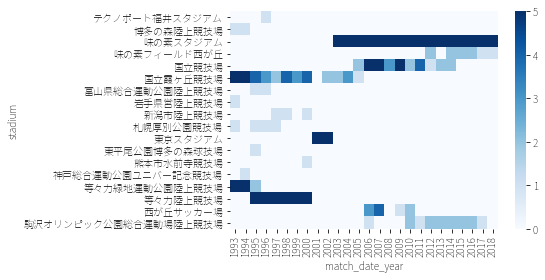

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
440,1994,横浜F,横浜市三ツ沢総合公園球技場,0.0,NaN,NaN,49,1
1588,1998,横浜F,鹿児島県立鴨池陸上競技場,12584.0,NaN,12584.0,32,1
733,1995,横浜F,熊本市水前寺競技場,15000.0,15000.0,15000.0,42,1
1610,1998,横浜F,横浜市三ツ沢公園球技場,15440.0,15046.0,15440.0,222,1
1124,1997,横浜F,富山県総合運動公園陸上競技場,18588.0,28494.0,18588.0,136,1
692,1995,横浜F,長崎県立総合運動公園陸上競技場,20246.0,20246.0,NaN,91,1
1295,1997,横浜F,国立霞ヶ丘競技場,48000.0,48000.0,NaN,200,1
1596,1998,横浜F,横浜国際総合競技場,72327.0,72327.0,NaN,93,1


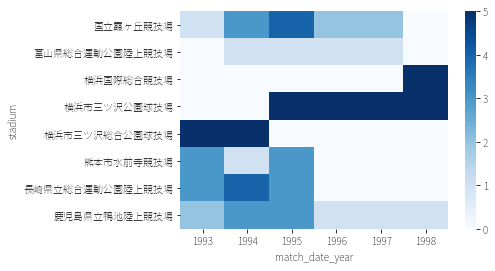

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
8522,2003,広島,広島スタジアム,0.0,NaN,NaN,66,1
135,1993,広島,びんご運動公園陸上競技場,9245.0,9245.0,NaN,1,1
381,1994,広島,福山市竹ケ端運動公園陸上競技場,10081.0,10081.0,NaN,1,1
998,1996,広島,鹿児島県立鴨池陸上競技場,12584.0,NaN,12584.0,32,1
5081,2011,広島,コカ・コーラウエスト広島スタジアム,13800.0,13800.0,13800.0,1,1
527,1995,広島,大分市営陸上競技場,16000.0,16000.0,NaN,58,1
966,1996,広島,鳥取市営サッカー場バードスタジアム,16033.0,16033.0,NaN,13,1
1125,1997,広島,愛媛県総合運動公園陸上競技場,20000.0,20000.0,NaN,56,1
250,1994,広島,博多の森陸上競技場,30000.0,30000.0,NaN,10,1
7324,2018,広島,エディオンスタジアム広島,36894.0,NaN,36894.0,101,1


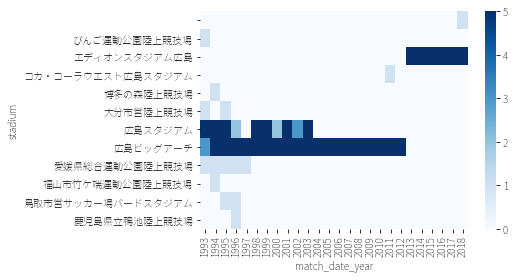

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
875,1996,鹿島,秋田市営八橋陸上競技場,0.0,NaN,NaN,5,1
1924,2000,鹿島,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
2082,2000,鹿島,鳥取市営サッカー場バードスタジアム,16033.0,16033.0,NaN,13,1
1909,2000,鹿島,富山県総合運動公園陸上競技場,18588.0,28494.0,18588.0,136,1
1659,1999,鹿島,石川県西部緑地公園陸上競技場,20261.0,20000.0,20261.0,100,1
7313,2018,鹿島,県立カシマサッカースタジアム,37496.0,40728.0,37496.0,415,1
2168,2001,鹿島,国立霞ヶ丘競技場,48000.0,48000.0,NaN,200,1
4914,2011,鹿島,国立競技場,54224.0,NaN,54224.0,88,1
7342,2018,鹿島,,NaN,NaN,NaN,0,1


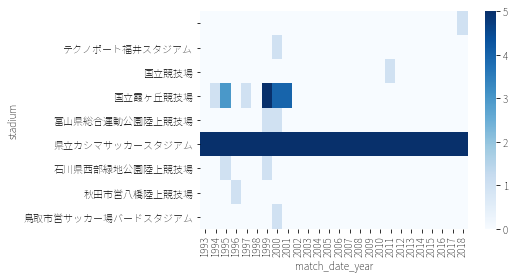

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
729,1995,G大阪,佐賀県総合運動場陸上競技場,17000.0,17000.0,17000.0,23,1
2936,2004,G大阪,岡山県陸上競技場桃太郎スタジアム,20000.0,20000.0,NaN,25,1
4736,2010,G大阪,石川県西部緑地公園陸上競技場,20261.0,20000.0,20261.0,100,1
553,1995,G大阪,京都市西京極総合運動公園陸上競技場,20588.0,20588.0,NaN,71,1
12093,2013,G大阪,万博記念競技場,21000.0,21000.0,21000.0,370,1
756,1995,G大阪,神戸総合運動公園ユニバー記念競技場,35910.0,35910.0,35910.0,139,1
7027,2017,G大阪,市立吹田サッカースタジアム,39694.0,39694.0,39694.0,34,1
7331,2018,G大阪,パナソニックスタジアム吹田,39694.0,39694.0,39694.0,16,1
7337,2018,G大阪,,NaN,NaN,NaN,0,1


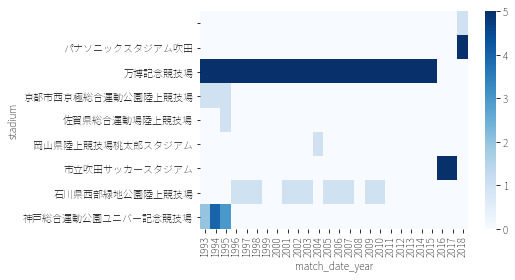

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
463,1995,清水,静岡県営草薙陸上競技場,0.0,NaN,NaN,19,1
324,1994,清水,札幌厚別公園競技場,19620.0,20861.0,19620.0,182,1
222,1994,清水,愛媛県総合運動公園陸上競技場,20000.0,20000.0,NaN,56,1
909,1996,清水,長崎県立総合運動公園陸上競技場,20246.0,20246.0,NaN,91,1
5509,2012,清水,アウトソーシングスタジアム日本平,20248.0,20339.0,20248.0,64,1
4272,2008,清水,日本平スタジアム,20248.0,20339.0,20248.0,186,1
13485,2016,清水,IAIスタジアム日本平,20248.0,20339.0,20248.0,102,1
750,1995,清水,石川県西部緑地公園陸上競技場,20261.0,20000.0,20261.0,100,1
800,1995,清水,日本平運動公園球技場,20339.0,20339.0,NaN,36,1
2745,2003,清水,静岡県草薙総合運動場陸上競技場,28000.0,28000.0,NaN,4,1


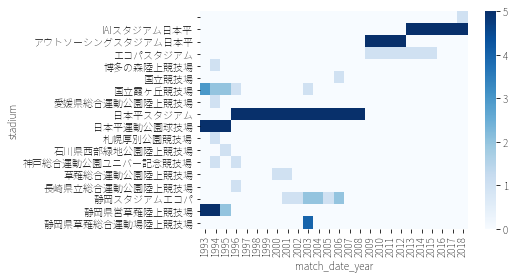

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
623,1995,浦和,埼玉県営大宮公園サッカー場,0.0,NaN,NaN,95,1
442,1994,浦和,富山県総合運動公園陸上競技場,18588.0,28494.0,18588.0,136,1
557,1995,浦和,新潟市陸上競技場,18671.0,18671.0,NaN,75,1
968,1996,浦和,札幌厚別公園競技場,19620.0,20861.0,19620.0,182,1
7747,2000,浦和,浦和駒場スタジアム,21500.0,21500.0,NaN,111,1
385,1994,浦和,博多の森陸上競技場,30000.0,30000.0,NaN,10,1
416,1994,浦和,神戸総合運動公園ユニバー記念競技場,35910.0,35910.0,35910.0,139,1
2412,2002,浦和,国立霞ヶ丘競技場,48000.0,48000.0,NaN,200,1
7319,2018,浦和,埼玉スタジアム2002,62010.0,63700.0,62010.0,274,1
7343,2018,浦和,,NaN,NaN,NaN,0,1


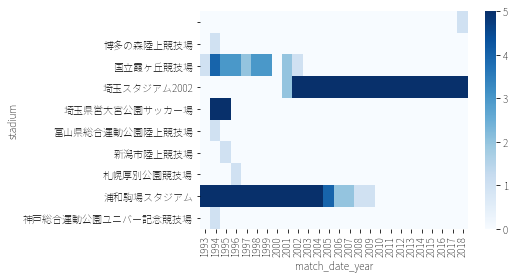

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
432,1994,横浜FM,横浜市三ツ沢総合公園球技場,0.0,NaN,NaN,49,1
3877,2007,横浜FM,横浜市三ツ沢公園球技場,15440.0,15046.0,15440.0,222,1
7287,2018,横浜FM,ニッパツ三ツ沢球技場,15440.0,15046.0,15440.0,249,1
303,1994,横浜FM,平塚競技場,15732.0,15200.0,15732.0,360,1
294,1994,横浜FM,栃木県立グリーンスタジアム,18025.0,18025.0,NaN,12,1
1779,1999,横浜FM,新潟市陸上競技場,18671.0,18671.0,NaN,75,1
605,1995,横浜FM,札幌厚別公園競技場,19620.0,20861.0,19620.0,182,1
958,1996,横浜FM,長崎県立総合運動公園陸上競技場,20246.0,20246.0,NaN,91,1
1444,1998,横浜FM,山形県総合運動公園陸上競技場,20315.0,20315.0,NaN,163,1
340,1994,横浜FM,博多の森陸上競技場,30000.0,30000.0,NaN,10,1


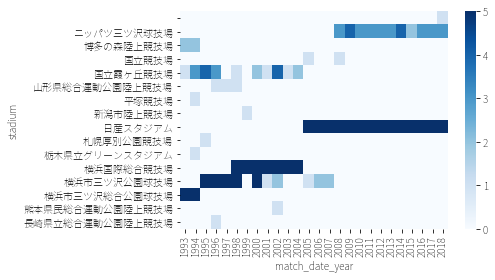

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
1276,1997,千葉,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
2138,2001,千葉,秋田市営八橋陸上競技場,0.0,NaN,NaN,5,1
145,1993,千葉,宮城陸上競技場,7000.0,7000.0,NaN,1,1
3286,2005,千葉,市原臨海競技場,14051.0,14051.0,NaN,165,1
366,1994,千葉,栃木県立グリーンスタジアム,18025.0,18025.0,NaN,12,1
383,1994,千葉,富山県総合運動公園陸上競技場,18588.0,28494.0,18588.0,136,1
1145,1997,千葉,新潟市陸上競技場,18671.0,18671.0,NaN,75,1
14414,2018,千葉,フクダ電子アリーナ,19470.0,19781.0,19470.0,257,1
626,1995,千葉,札幌厚別公園競技場,19620.0,20861.0,19620.0,182,1
1928,2000,千葉,仙台スタジアム,19694.0,19694.0,NaN,129,1


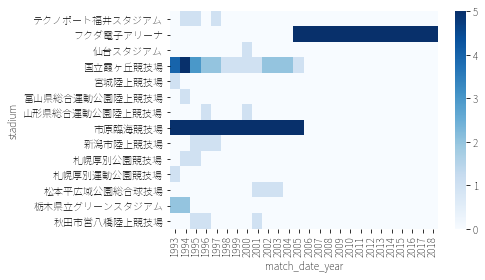

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
107,1993,名古屋,三重県営鈴鹿スポーツガーデン,0.0,NaN,NaN,3,1
258,1994,名古屋,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
1708,1999,名古屋,岐阜メモリアルセンター長良川競技場,16300.0,26109.0,16300.0,235,1
311,1994,名古屋,名古屋市港サッカー場,20000.0,20000.0,NaN,1,1
3912,2007,名古屋,名古屋市瑞穂球技場,20223.0,NaN,20223.0,24,1
6151,2015,名古屋,名古屋市瑞穂陸上競技場,20223.0,27000.0,20223.0,205,1
13927,2017,名古屋,パロマ瑞穂スタジアム,20223.0,27000.0,20223.0,34,1
796,1995,名古屋,瑞穂公園陸上競技場,27000.0,27000.0,NaN,23,1
122,1993,名古屋,博多の森陸上競技場,30000.0,30000.0,NaN,10,1
298,1994,名古屋,神戸総合運動公園ユニバー記念競技場,35910.0,35910.0,35910.0,139,1


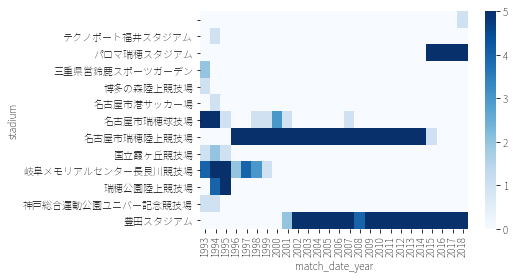

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
198,1994,磐田,静岡県営草薙陸上競技場,0.0,NaN,NaN,19,1
570,1995,磐田,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
804,1995,磐田,ジュビロ磐田サッカースタジアム,15165.0,15165.0,NaN,45,1
2811,2003,磐田,ジュビロ磐田スタジアム,15165.0,15165.0,NaN,116,1
13020,2015,磐田,ヤマハスタジアム(磐田),15165.0,15165.0,15165.0,220,1
710,1995,磐田,国立霞ヶ丘競技場,48000.0,48000.0,NaN,200,1
3662,2006,磐田,静岡スタジアムエコパ,51697.0,50889.0,51697.0,28,1
7090,2018,磐田,エコパスタジアム,51697.0,50889.0,51697.0,35,1
7336,2018,磐田,,NaN,NaN,NaN,0,1


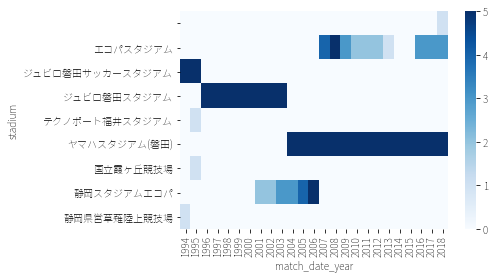

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
11170,2011,湘南,平塚競技場,15732.0,15200.0,15732.0,360,1
13959,2017,湘南,ShonanBMWスタジアム平塚,15732.0,15200.0,15732.0,130,1
926,1996,湘南,新潟市陸上競技場,18671.0,18671.0,NaN,75,1
592,1995,湘南,愛媛県総合運動公園陸上競技場,20000.0,20000.0,NaN,56,1
1666,1999,湘南,国立霞ヶ丘競技場,48000.0,48000.0,NaN,200,1
7334,2018,湘南,,NaN,NaN,NaN,0,1


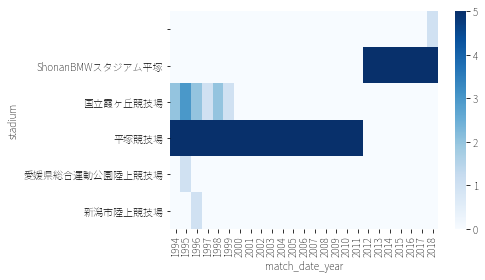

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
7323,2018,柏,三協フロンテア柏スタジアム,15109.0,15349.0,15109.0,16,1
10792,2010,柏,日立柏サッカー場,15109.0,15349.0,15109.0,333,1
947,1996,柏,新潟市陸上競技場,18671.0,18671.0,NaN,75,1
9331,2006,柏,柏の葉公園総合競技場,20000.0,20000.0,20000.0,31,1
3108,2005,柏,国立霞ヶ丘競技場,48000.0,48000.0,NaN,200,1
5656,2013,柏,国立競技場,54224.0,NaN,54224.0,88,1
7344,2018,柏,,NaN,NaN,NaN,0,1


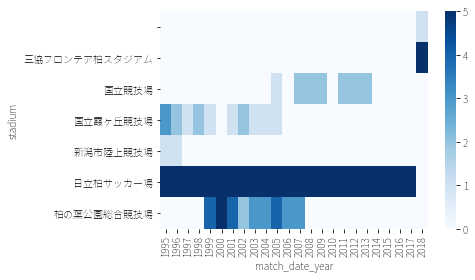

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
8147,2002,C大阪,三重県営鈴鹿スポーツガーデン,0.0,NaN,NaN,3,1
9568,2007,C大阪,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
8096,2002,C大阪,大津市皇子山総合運動公園陸上競技場,15000.0,15000.0,NaN,2,1
8206,2002,C大阪,大阪長居第2陸上競技場,15516.0,47000.0,15516.0,45,1
1301,1997,C大阪,大分市営陸上競技場,16000.0,16000.0,NaN,58,1
9585,2007,C大阪,鳥取市営サッカー場バードスタジアム,16033.0,16033.0,NaN,13,1
13489,2016,C大阪,キンチョウスタジアム,17892.0,19904.0,17892.0,94,1
878,1996,C大阪,愛媛県総合運動公園陸上競技場,20000.0,20000.0,NaN,56,1
9605,2007,C大阪,三木総合防災公園陸上競技場,20000.0,20000.0,NaN,2,1
748,1995,C大阪,京都市西京極総合運動公園陸上競技場,20588.0,20588.0,NaN,71,1


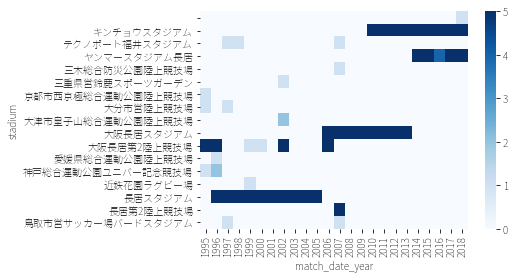

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
8755,2004,福岡,北九州市立本城陸上競技場,10000.0,10000.0,NaN,144,1
1390,1998,福岡,熊本市水前寺競技場,15000.0,15000.0,15000.0,42,1
9633,2007,福岡,長崎県立総合運動公園陸上競技場,20246.0,20246.0,NaN,91,1
9689,2007,福岡,東平尾公園博多の森球技場,22331.0,22563.0,22331.0,213,1
14408,2018,福岡,レベルファイブスタジアム,22331.0,22563.0,22331.0,224,1
8505,2003,福岡,東平尾公園博多の森陸上競技場,30000.0,30000.0,NaN,1,1


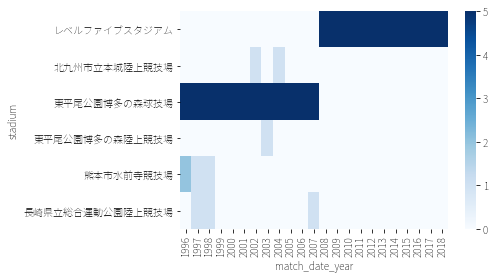

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
9508,2007,京都,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
12250,2014,京都,鹿児島県立鴨池陸上競技場,12584.0,NaN,12584.0,32,1
7836,2001,京都,鳥取市営サッカー場バードスタジアム,16033.0,16033.0,NaN,13,1
1375,1998,京都,富山県総合運動公園陸上競技場,18588.0,28494.0,18588.0,136,1
1118,1997,京都,石川県西部緑地公園陸上競技場,20261.0,20000.0,20261.0,100,1
2092,2000,京都,京都市西京極総合運動公園陸上競技場,20588.0,20588.0,NaN,71,1
14404,2018,京都,京都市西京極総合運動公園陸上競技場兼球技場,20588.0,20588.0,20588.0,338,1
8668,2004,京都,高知県立春野総合運動公園陸上競技場,25000.0,25000.0,NaN,6,1


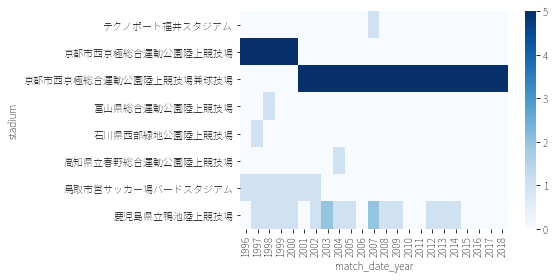

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
9375,2006,神戸,神戸ウイングスタジアム,0.0,NaN,NaN,57,1
2545,2002,神戸,鳥取市営サッカー場バードスタジアム,16033.0,16033.0,NaN,13,1
2506,2002,神戸,徳島県鳴門総合運動公園陸上競技場,17924.0,17924.0,NaN,51,1
3228,2005,神戸,岡山県陸上競技場桃太郎スタジアム,20000.0,20000.0,NaN,25,1
9305,2006,神戸,三木総合防災公園陸上競技場,20000.0,20000.0,NaN,2,1
5512,2012,神戸,ホームズスタジアム神戸,28425.0,30132.0,28425.0,93,1
12113,2013,神戸,ノエビアスタジアム神戸,28425.0,30132.0,28425.0,97,1
12023,2013,神戸,神戸総合運動公園ユニバー記念競技場,35910.0,35910.0,35910.0,139,1
7348,2018,神戸,,NaN,NaN,NaN,0,1


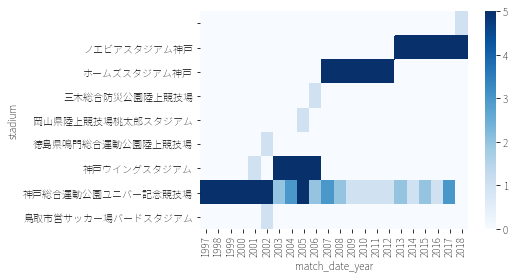

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
1366,1998,札幌,七北田公園仙台スタジアム,0.0,NaN,NaN,2,1
9426,2007,札幌,西が丘サッカー場,7137.0,7137.0,NaN,15,1
10900,2011,札幌,室蘭市入江運動公園陸上競技場,12600.0,12600.0,NaN,21,1
7565,2000,札幌,千代台公園陸上競技場,15000.0,15000.0,NaN,2,1
13253,2016,札幌,函館市千代台公園陸上競技場,15000.0,15000.0,NaN,10,1
13412,2016,札幌,札幌厚別公園競技場,19620.0,20861.0,19620.0,182,1
2354,2002,札幌,高知県立春野総合運動公園陸上競技場,25000.0,25000.0,NaN,6,1
13490,2016,札幌,札幌ドーム,39856.0,NaN,39856.0,202,1
7341,2018,札幌,,NaN,NaN,NaN,0,1


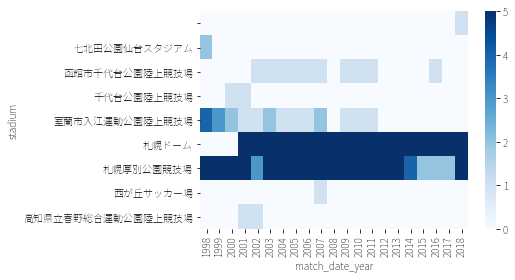

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
7502,1999,FC東京,江戸川区陸上競技場,6950.0,6950.0,NaN,9,1
7499,1999,FC東京,国立西が丘サッカー場,7137.0,7137.0,NaN,11,1
1929,2000,FC東京,鹿児島県立鴨池陸上競技場,12584.0,NaN,12584.0,32,1
11037,2011,FC東京,熊谷スポーツ文化公園陸上競技場,15002.0,15392.0,15002.0,27,1
7521,1999,FC東京,駒沢陸上競技場,20010.0,20010.0,NaN,5,1
10899,2011,FC東京,駒沢オリンピック公園総合運動場陸上競技場,20010.0,20010.0,20010.0,18,1
2042,2000,FC東京,石川県西部緑地公園陸上競技場,20261.0,20000.0,20261.0,100,1
3489,2006,FC東京,松本平広域公園総合球技場,20336.0,20000.0,20336.0,150,1
2162,2001,FC東京,香川県立丸亀競技場,30099.0,30099.0,NaN,38,1
3015,2004,FC東京,国立霞ヶ丘競技場,48000.0,48000.0,NaN,200,1


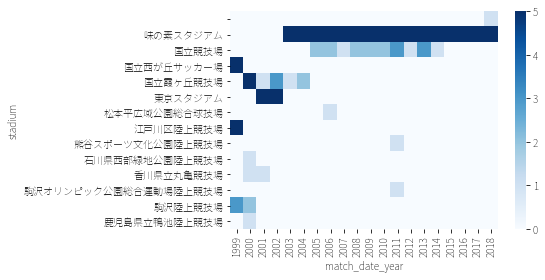

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
7497,1999,川崎F,長野運動公園総合運動場,0.0,NaN,NaN,1,1
7966,2001,川崎F,長野市営長野運動公園総合運動場,0.0,NaN,NaN,1,1
7978,2001,川崎F,江戸川区陸上競技場,6950.0,6950.0,NaN,9,1
7991,2001,川崎F,国立スポーツ科学センター西が丘サッカー場,7137.0,7137.0,NaN,2,1
8002,2001,川崎F,町田市立陸上競技場,10328.0,10622.0,10328.0,84,1
8794,2004,川崎F,等々力陸上競技場,26827.0,26232.0,26827.0,422,1
2004,2000,川崎F,国立霞ヶ丘競技場,48000.0,48000.0,NaN,200,1
5529,2013,川崎F,国立競技場,54224.0,NaN,54224.0,88,1
7440,1999,川崎F,横浜国際総合競技場,72327.0,72327.0,NaN,93,1
7345,2018,川崎F,,NaN,NaN,NaN,0,1


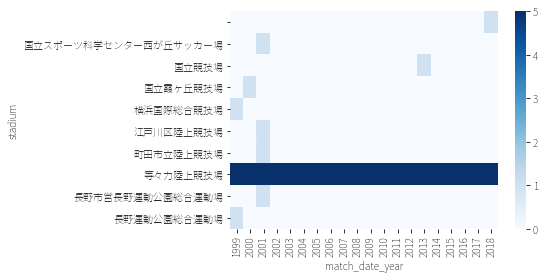

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
9060,2005,仙台,仙台スタジアム,19694.0,19694.0,NaN,129,1
10463,2009,仙台,ユアテックスタジアム仙台,19694.0,19694.0,19694.0,230,1
10154,2009,仙台,福島県営あづま陸上競技場,21000.0,21000.0,NaN,3,1
10216,2009,仙台,宮城スタジアム,49133.0,49133.0,49133.0,22,1
7332,2018,仙台,,NaN,NaN,NaN,0,1


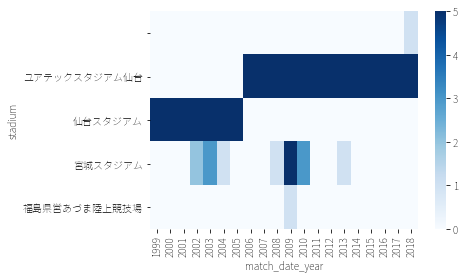

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
7609,2000,大分,佐伯市営陸上競技場,5000.0,5000.0,NaN,5,1
10684,2010,大分,鹿児島県立鴨池陸上競技場,12584.0,NaN,12584.0,32,1
7692,2000,大分,熊本市水前寺競技場,15000.0,15000.0,15000.0,42,1
8251,2002,大分,大分市営陸上競技場,16000.0,16000.0,NaN,58,1
8101,2002,大分,長崎県立総合運動公園陸上競技場,20246.0,20246.0,NaN,91,1
8115,2002,大分,熊本県民総合運動公園陸上競技場,30684.0,32000.0,30684.0,92,1
4595,2009,大分,九州石油ドーム,31997.0,40000.0,31997.0,65,1
14402,2018,大分,大分銀行ドーム,31997.0,40000.0,31997.0,158,1
8277,2002,大分,大分スポーツ公園総合競技場,40000.0,40000.0,NaN,62,1


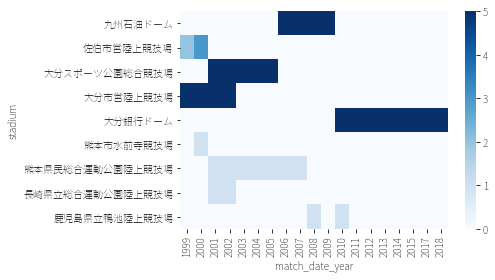

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
8463,2003,新潟,新潟市陸上競技場,18671.0,18671.0,NaN,75,1
6125,2014,新潟,県立カシマサッカースタジアム,37496.0,40728.0,37496.0,415,1
5816,2013,新潟,東北電力ビッグスワンスタジアム,41684.0,42300.0,41684.0,119,1
8541,2003,新潟,新潟スタジアム,41684.0,42300.0,41684.0,88,1
14415,2018,新潟,デンカビッグスワンスタジアム,41684.0,42300.0,41684.0,88,1
3041,2004,新潟,国立霞ヶ丘競技場,48000.0,48000.0,NaN,200,1


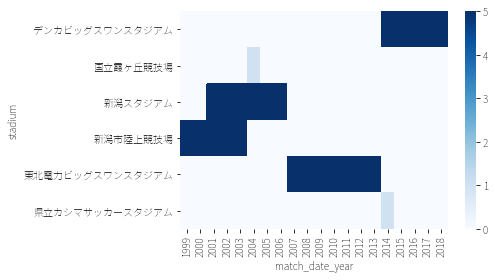

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
8322,2003,大宮,埼玉県営大宮公園サッカー場,0.0,NaN,NaN,95,1
7885,2001,大宮,鴻巣市立陸上競技場,5000.0,5000.0,NaN,3,1
7708,2000,大宮,国立西が丘サッカー場,7137.0,7137.0,NaN,11,1
14311,2018,大宮,熊谷スポーツ文化公園陸上競技場,15002.0,15392.0,15002.0,27,1
14405,2018,大宮,NACK5スタジアム大宮,15491.0,15500.0,15491.0,182,1
8803,2004,大宮,さいたま市大宮公園サッカー場,15500.0,15500.0,NaN,40,1
7496,1999,大宮,栃木県立グリーンスタジアム,18025.0,18025.0,NaN,12,1
8201,2002,大宮,浦和駒場スタジアム,21500.0,21500.0,21500.0,66,1
8677,2004,大宮,埼玉スタジアム2002,62010.0,63700.0,62010.0,274,1


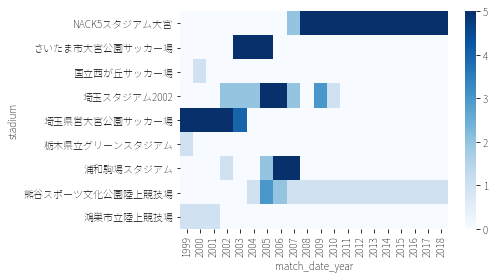

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
7705,2000,甲府,都市公園富士北麓公園陸上競技場,0.0,NaN,NaN,2,1
7564,2000,甲府,韮崎中央公園陸上競技場,4000.0,4000.0,NaN,5,1
10803,2010,甲府,山梨県小瀬スポーツ公園陸上競技場,15859.0,17000.0,15859.0,234,1
14421,2018,甲府,山梨中銀スタジアム,15859.0,17000.0,15859.0,141,1
8866,2005,甲府,松本平広域公園総合球技場,20336.0,20000.0,20336.0,150,1
5924,2014,甲府,国立競技場,54224.0,NaN,54224.0,88,1


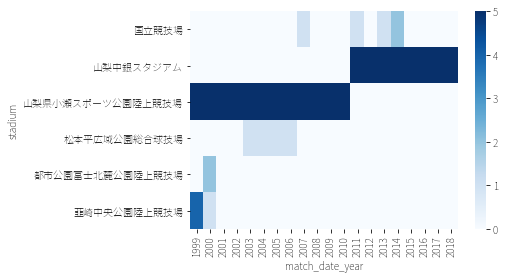

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
7948,2001,横浜FC,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
8753,2004,横浜FC,江東区夢の島競技場,2429.0,5050.0,2429.0,7,1
8189,2002,横浜FC,横浜市三ツ沢公園陸上競技場,5425.0,18300.0,5425.0,6,1
9000,2005,横浜FC,江戸川区陸上競技場,6950.0,6950.0,NaN,9,1
7826,2001,横浜FC,国立スポーツ科学センター西が丘サッカー場,7137.0,7137.0,NaN,2,1
11046,2011,横浜FC,西が丘サッカー場,7137.0,7137.0,NaN,15,1
12988,2015,横浜FC,味の素フィールド西が丘,7258.0,7137.0,7258.0,13,1
9380,2006,横浜FC,横浜市三ツ沢公園球技場,15440.0,15046.0,15440.0,222,1
14403,2018,横浜FC,ニッパツ三ツ沢球技場,15440.0,15046.0,15440.0,249,1
10443,2009,横浜FC,駒沢オリンピック公園総合運動場陸上競技場,20010.0,20010.0,20010.0,18,1


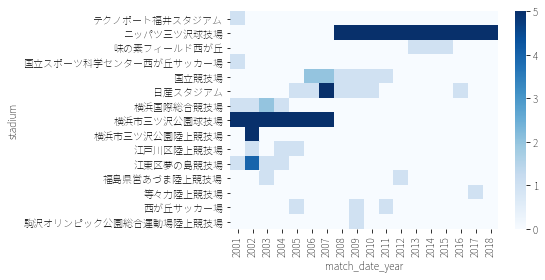

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
8649,2004,山形,秋田市営八橋陸上競技場,0.0,NaN,NaN,5,1
8843,2005,山形,Jヴィレッジスタジアム,0.0,NaN,NaN,1,1
7992,2001,山形,鶴岡市小真木原陸上競技場,7000.0,7000.0,NaN,6,1
7918,2001,山形,山形市陸上競技場,9000.0,9000.0,NaN,6,1
9378,2006,山形,山形県総合運動公園陸上競技場,20315.0,20315.0,NaN,163,1
14417,2018,山形,NDソフトスタジアム山形,20784.0,20315.0,20784.0,239,1


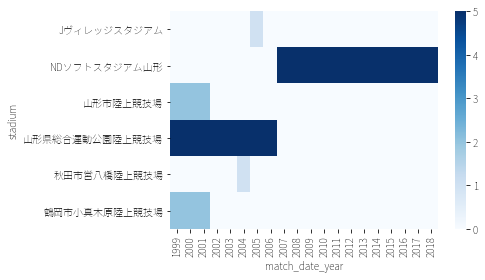

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
10736,2010,鳥栖,佐賀県総合運動場陸上競技場,17000.0,17000.0,17000.0,23,1
7898,2001,鳥栖,長崎県立総合運動公園陸上競技場,20246.0,20246.0,NaN,91,1
9684,2007,鳥栖,鳥栖スタジアム,24130.0,24130.0,NaN,179,1
11183,2011,鳥栖,ベストアメニティスタジアム,24130.0,24130.0,24130.0,196,1
7971,2001,鳥栖,沖縄県総合運動公園陸上競技場,25000.0,25000.0,NaN,1,1
7340,2018,鳥栖,,NaN,NaN,NaN,0,1


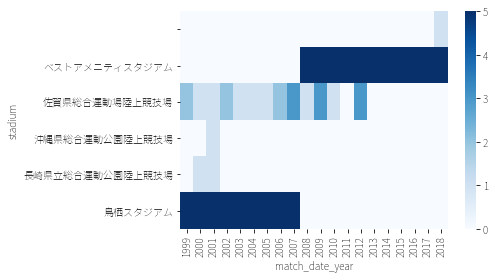

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
9451,2007,徳島,徳島県鳴門総合運動公園陸上競技場,17924.0,17924.0,NaN,51,1
14411,2018,徳島,鳴門・大塚スポーツパークポカリスエットスタジアム,17924.0,17924.0,17924.0,244,1
9355,2006,徳島,高知県立春野総合運動公園陸上競技場,25000.0,25000.0,NaN,6,1
9632,2007,徳島,香川県立丸亀競技場,30099.0,30099.0,NaN,38,1


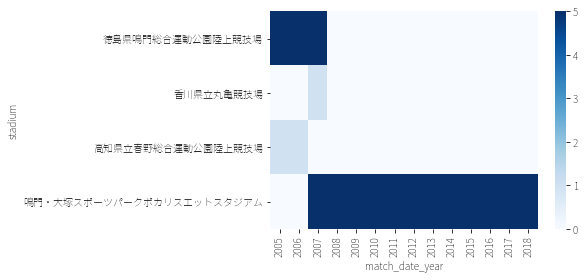

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
14003,2018,松本,山梨中銀スタジアム,15859.0,17000.0,15859.0,141,1
14418,2018,松本,サンプロアルウィン,20000.0,20000.0,NaN,4,1
14329,2018,松本,松本平広域公園総合球技場,20336.0,20000.0,20336.0,150,1


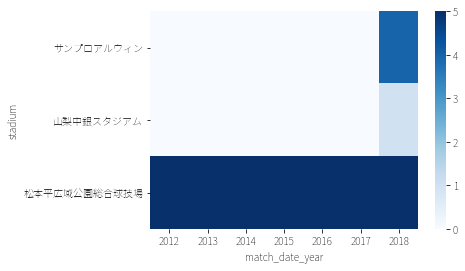

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
12528,2014,長崎,長崎市総合運動公園かきどまり陸上競技場,16000.0,5770.0,16000.0,3,1
13310,2016,長崎,長崎県立総合運動公園陸上競技場,20246.0,20246.0,NaN,91,1
13946,2017,長崎,トランスコスモススタジアム長崎,20258.0,20246.0,20258.0,46,1
7349,2018,長崎,,NaN,NaN,NaN,0,1


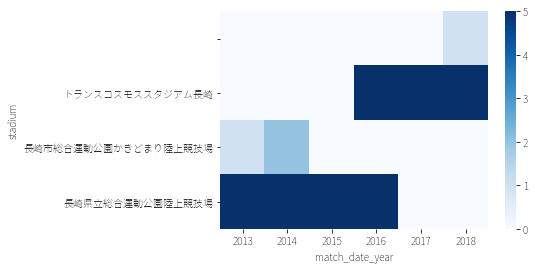

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
10203,2009,水戸,ひたちなか市総合運動公園陸上競技場,0.0,NaN,NaN,42,1
9671,2007,水戸,足利市総合運動公園陸上競技場,7500.0,7500.0,NaN,3,1
9946,2008,水戸,日立市民運動公園陸上競技場,8464.0,8464.0,NaN,11,1
14409,2018,水戸,ケーズデンキスタジアム水戸,10152.0,12000.0,10152.0,181,1
9512,2007,水戸,水戸市立競技場,12000.0,12000.0,NaN,12,1
8560,2004,水戸,栃木県立グリーンスタジアム,18025.0,18025.0,NaN,12,1
12697,2015,水戸,笠松運動公園陸上競技場,22002.0,22002.0,NaN,155,1


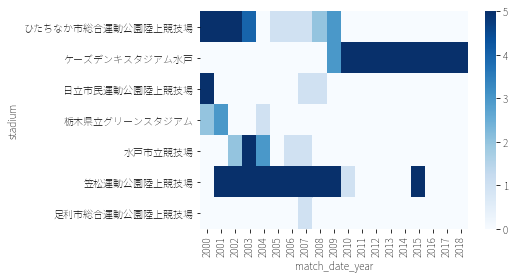

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
8909,2005,群馬,群馬県立敷島公園県営サッカー・ラグビー場,0.0,NaN,NaN,10,1
9046,2005,群馬,足利市総合運動公園陸上競技場,7500.0,7500.0,NaN,3,1
12395,2014,群馬,熊谷スポーツ文化公園陸上競技場,15002.0,15392.0,15002.0,27,1
13961,2017,群馬,正田醤油スタジアム群馬,15190.0,15253.0,15190.0,201,1
9729,2008,群馬,群馬県立敷島公園県営陸上競技場,15253.0,15253.0,NaN,57,1
10342,2009,群馬,松本平広域公園総合球技場,20336.0,20000.0,20336.0,150,1


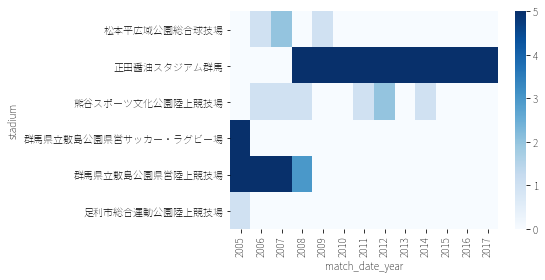

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
9692,2007,愛媛,愛媛県総合運動公園陸上競技場,20000.0,20000.0,NaN,56,1
14412,2018,愛媛,ニンジニアスタジアム,20919.0,20000.0,20919.0,230,1
10296,2009,愛媛,高知県立春野総合運動公園陸上競技場,25000.0,25000.0,NaN,6,1


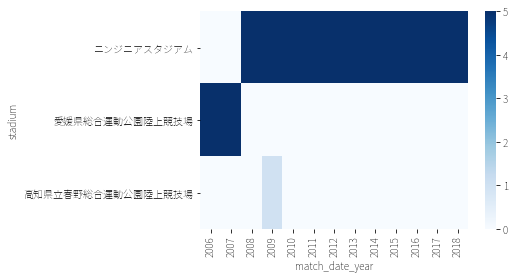

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
9891,2008,熊本,鹿児島県立鴨池陸上競技場,12584.0,NaN,12584.0,32,1
14150,2018,熊本,熊本市水前寺競技場,15000.0,15000.0,15000.0,42,1
13181,2016,熊本,日立柏サッカー場,15109.0,15349.0,15109.0,333,1
13235,2016,熊本,ベストアメニティスタジアム,24130.0,24130.0,24130.0,196,1
13194,2016,熊本,ノエビアスタジアム神戸,28425.0,30132.0,28425.0,97,1
11649,2012,熊本,熊本県民総合運動公園陸上競技場,30684.0,32000.0,30684.0,92,1
14413,2018,熊本,えがお健康スタジアム,30684.0,32000.0,30684.0,40,1
13482,2016,熊本,うまかな・よかなスタジアム,32000.0,32000.0,NaN,72,1


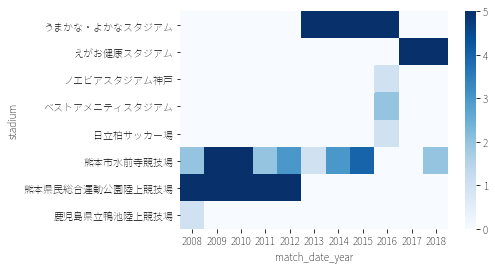

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
11604,2012,岐阜,岐阜メモリアルセンター長良川球技メドウ,0.0,NaN,NaN,19,1
12018,2013,岐阜,大垣市浅中公園総合グラウンド陸上競技場,4300.0,4300.0,NaN,1,1
14422,2018,岐阜,岐阜メモリアルセンター長良川競技場,16300.0,26109.0,16300.0,235,1


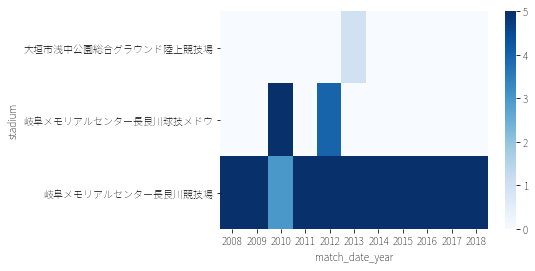

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
10072,2009,栃木,西が丘サッカー場,7137.0,7137.0,NaN,15,1
10388,2009,栃木,足利市総合運動公園陸上競技場,7500.0,7500.0,NaN,3,1
10171,2009,栃木,熊谷スポーツ文化公園陸上競技場,15002.0,15392.0,15002.0,27,1
14410,2018,栃木,栃木県グリーンスタジアム,15325.0,18025.0,15325.0,163,1
10036,2009,栃木,国立競技場,54224.0,NaN,54224.0,88,1


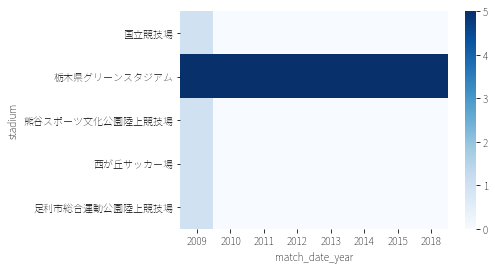

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
12950,2015,岡山,岡山県津山陸上競技場,10000.0,10000.0,10000.0,5,1
10398,2009,岡山,とりぎんバードスタジアム,11999.0,16033.0,11999.0,62,1
14420,2018,岡山,シティライトスタジアム,15479.0,20000.0,15479.0,83,1
10450,2009,岡山,岡山県陸上競技場桃太郎スタジアム,20000.0,20000.0,NaN,25,1
12559,2014,岡山,kankoスタジアム,20000.0,20000.0,NaN,97,1


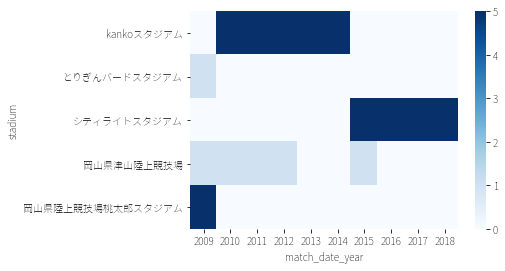

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
12573,2014,富山,富山県総合運動公園陸上競技場,18588.0,28494.0,18588.0,136,1


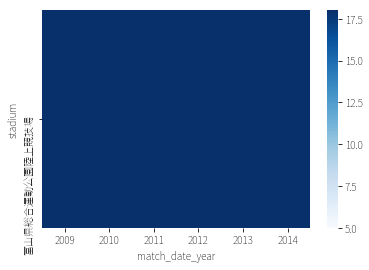

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
13483,2016,北九州,北九州市立本城陸上競技場,10000.0,10000.0,NaN,144,1


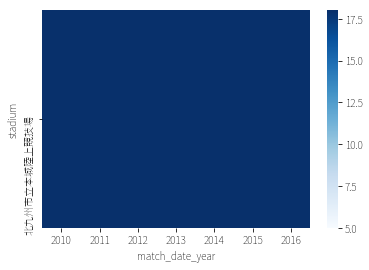

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
12110,2013,鳥取,とりぎんバードスタジアム,11999.0,16033.0,11999.0,62,1


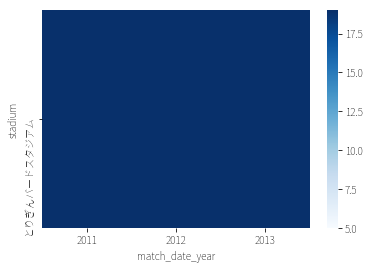

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
14416,2018,町田,町田市立陸上競技場,10328.0,10622.0,10328.0,84,1
11205,2012,町田,駒沢オリンピック公園総合運動場陸上競技場,20010.0,20010.0,20010.0,18,1


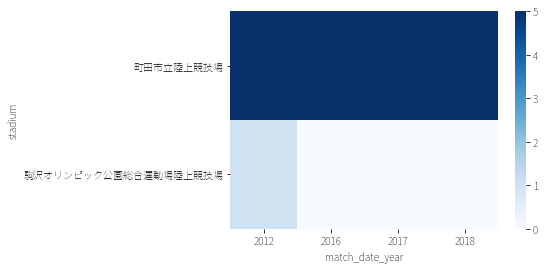

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
14423,2018,讃岐,Pikaraスタジアム,22338.0,30099.0,22338.0,70,1
12875,2015,讃岐,香川県立丸亀競技場,30099.0,30099.0,NaN,38,1


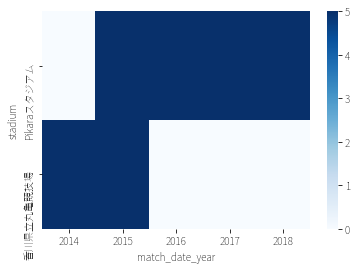

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
14419,2018,金沢,石川県西部緑地公園陸上競技場,20261.0,20000.0,20261.0,100,1


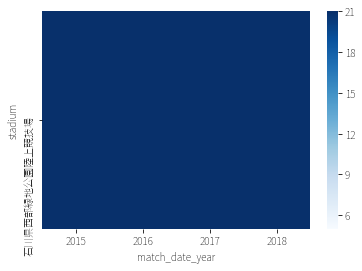

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
14351,2018,山口,下関市営下関陸上競技場,9430.0,23939.0,9430.0,5,1
14407,2018,山口,維新みらいふスタジアム,15115.0,20000.0,15115.0,19,1
13954,2017,山口,維新百年記念公園陸上競技場,20000.0,20000.0,NaN,39,1


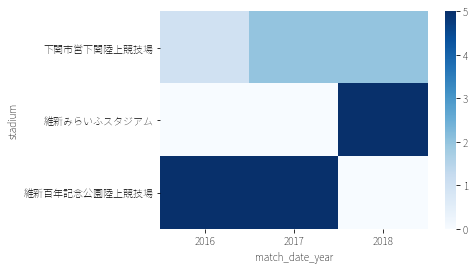

In [36]:
# ここで表記ゆれを確認する

for team in checker_df.home_team.unique():
    tmp = checker_df.query("home_team == '{}'".format(team))
    display(tmp.drop_duplicates("stadium", keep="last").sort_values("capacity"))
    sns.heatmap(
            tmp.pivot_table(columns="match_date_year",
                            index="stadium",
                            values="appear",
                            aggfunc="sum").fillna(0),
            cmap="Blues",
            vmax=5,
             )
    plt.show()

In [37]:
name_pairs = [["国立競技場", "国立霞ヶ丘競技場"],
              ["味の素フィールド西が丘", "西が丘サッカー場", "国立西が丘サッカー場", "国立スポーツ科学センター西が丘サッカー場"],
              ["コカ・コーラウエスト広島スタジアム", "広島スタジアム"],
              ["エディオンスタジアム広島", "広島ビッグアーチ"],
              ["パナソニックスタジアム吹田", "市立吹田サッカースタジアム"],
              ["IAIスタジアム日本平", "アウトソーシングスタジアム日本平", "日本平スタジアム","日本平運動公園球技場"],
              ["エコパスタジアム", "静岡スタジアムエコパ"],
              ["草薙総合運動公園陸上競技場", "静岡県草薙総合運動場陸上競技場", "静岡県営草薙陸上競技場"],
              ["ニッパツ三ツ沢球技場", "横浜市三ツ沢公園球技場", "横浜市三ツ沢総合公園球技場"],
              ["パロマ瑞穂スタジアム", "名古屋市瑞穂陸上競技場", "名古屋市瑞穂球技場", "瑞穂公園陸上競技場"],
              ["エコパスタジアム", "静岡スタジアムエコパ"],
              ["ヤマハスタジアム(磐田)", "ジュビロ磐田スタジアム", "ジュビロ磐田サッカースタジアム"],
              ["ShonanBMWスタジアム平塚", "平塚競技場"],
              ["三協フロンテア柏スタジアム", "日立柏サッカー場"],
              ["ヤンマースタジアム長居", "大阪長居スタジアム", "長居スタジアム"],
              ["キンチョウスタジアム", "大阪長居第2陸上競技場", "長居第2陸上競技場"],
              ["レベルファイブスタジアム", "東平尾公園博多の森球技場", "博多の森陸上競技場", "東平尾公園博多の森陸上競技場"],
              ["京都市西京極総合運動公園陸上競技場兼球技場", "京都市西京極総合運動公園陸上競技場"],
              ["ノエビアスタジアム神戸", "神戸ウイングスタジアム", "ホームズスタジアム神戸"],
              ["函館市千代台公園陸上競技場", "千代台公園陸上競技場"],
              ["味の素スタジアム", "東京スタジアム"],
              ["駒沢オリンピック公園総合運動場陸上競技場", "駒沢陸上競技場"],
              ["ユアテックスタジアム仙台", "仙台スタジアム", "七北田公園仙台スタジアム"],
              ["大分銀行ドーム", "九州石油ドーム", "大分スポーツ公園総合競技場"],
              ["デンカビッグスワンスタジアム", "東北電力ビッグスワンスタジアム", "新潟スタジアム"],
              ["NACK5スタジアム大宮", "さいたま市大宮公園サッカー場", "埼玉県営大宮公園サッカー場"],
              ["山梨中銀スタジアム", "山梨県小瀬スポーツ公園陸上競技場"],
              ["NDソフトスタジアム山形", "山形県総合運動公園陸上競技場"],
              ["ベストアメニティスタジアム", "鳥栖スタジアム"],
              ["鳴門・大塚スポーツパークポカリスエットスタジアム", "徳島県鳴門総合運動公園陸上競技場"],
              ["松本平広域公園総合球技場", "サンプロアルウィン"],
              ["トランスコスモススタジアム長崎", "長崎県立総合運動公園陸上競技場"],
              ["ケーズデンキスタジアム水戸", "水戸市立競技場"],
              ["正田醤油スタジアム群馬", "群馬県立敷島公園県営陸上競技場"],
              ["ニンジニアスタジアム", "愛媛県総合運動公園陸上競技場"],
              ["えがお健康スタジアム", "うまかな・よかなスタジアム", "熊本県民総合運動公園陸上競技場"],
              # ["岐阜メモリアルセンター長良川競技場", "岐阜メモリアルセンター長良川球技メドウ"], この二つは実は別スタジアム
              ["シティライトスタジアム", "kankoスタジアム", "岡山県陸上競技場桃太郎スタジアム"],
              ["Pikaraスタジアム", "香川県立丸亀競技場"],
              ["維新みらいふスタジアム", "維新百年記念公園陸上競技場"],
              ["札幌厚別公園競技場", "札幌厚別運動公園競技場"],
              ["等々力陸上競技場", "等々力緑地運動公園陸上競技場"],
              ["日産スタジアム", "横浜国際総合競技場"],
              ["とりぎんバードスタジアム", "鳥取市営サッカー場バードスタジアム"],
              ["長野運動公園総合運動場", "長野市営長野運動公園総合運動場"]
              ]
              
              
for pair in name_pairs:
    for i in range(1, len(pair)):
        UFT.unite([pair[0], pair[i]])

In [38]:
replace_dic = UFT.make_replace_dic()
ex_total_df["venue"] = ex_total_df["venue"].replace(replace_dic)
checker_df = ex_total_df[["match_date_year", "home_team", "venue"]].rename(columns={"venue": "stadium"})\
                                                                   .merge(stadium_df[["stadium",
                                                                                      "capacity",
                                                                                      "dirty_capacity",
                                                                                      "clean_capacity"]],
                                                                          how="left",
                                                                          on="stadium")

tmp = checker_df.groupby("stadium")["capacity"].count().reset_index(name="total_appear")
checker_df = checker_df.merge(tmp,
                              how="left",
                              on="stadium")
checker_df["appear"] = 1

In [62]:
sorted(replace_dic)

['kankoスタジアム',
 'うまかな・よかなスタジアム',
 'さいたま市大宮公園サッカー場',
 'さいたま市浦和駒場スタジアム',
 'ひとめぼれスタジアム宮城',
 'アウトソーシングスタジアム日本平',
 'サンプロアルウィン',
 'ジュビロ磐田サッカースタジアム',
 'ジュビロ磐田スタジアム',
 'ホームズスタジアム神戸',
 '七北田公園仙台スタジアム',
 '九州石油ドーム',
 '京都市西京極総合運動公園陸上競技場',
 '仙台スタジアム',
 '千代台公園陸上競技場',
 '博多の森陸上競技場',
 '名古屋市瑞穂球技場',
 '名古屋市瑞穂陸上競技場',
 '国立スポーツ科学センター西が丘サッカー場',
 '国立西が丘サッカー場',
 '国立霞ヶ丘競技場',
 '埼玉県営大宮公園サッカー場',
 '大分スポーツ公園総合競技場',
 '大阪長居スタジアム',
 '大阪長居第2陸上競技場',
 '山形県総合運動公園陸上競技場',
 '山梨県小瀬スポーツ公園陸上競技場',
 '岡山県陸上競技場桃太郎スタジアム',
 '市立吹田サッカースタジアム',
 '平塚競技場',
 '広島スタジアム',
 '広島ビッグアーチ',
 '徳島県鳴門総合運動公園陸上競技場',
 '愛媛県総合運動公園陸上競技場',
 '新潟スタジアム',
 '日本平スタジアム',
 '日本平運動公園球技場',
 '日立柏サッカー場',
 '札幌厚別運動公園競技場',
 '東京スタジアム',
 '東北電力ビッグスワンスタジアム',
 '東平尾公園博多の森球技場',
 '東平尾公園博多の森陸上競技場',
 '横浜国際総合競技場',
 '横浜市三ツ沢公園球技場',
 '横浜市三ツ沢総合公園球技場',
 '水戸市立競技場',
 '浦和市駒場スタジアム',
 '熊本県民総合運動公園陸上競技場',
 '瑞穂公園陸上競技場',
 '白波スタジアム',
 '神戸ウイングスタジアム',
 '等々力緑地運動公園陸上競技場',
 '維新百年記念公園陸上競技場',
 '群馬県立敷島公園県営陸上競技場',
 '西が丘サッカー場',
 '長居スタジアム',
 '長居第2陸上競技場',
 '長崎県立総合運動公園陸上競技場',
 '長野市営長野運動公園総合運動場',
 '静岡スタジアムエコパ',
 '静岡県

In [63]:
tmp = {'kankoスタジアム': 'シティライトスタジアム',
                   'うまかな・よかなスタジアム': 'えがお健康スタジアム',
                   'さいたま市大宮公園サッカー場': 'NACK5スタジアム大宮',
                   'さいたま市浦和駒場スタジアム': '浦和駒場スタジアム',
                   'ひとめぼれスタジアム宮城': '宮城スタジアム',
                   'アウトソーシングスタジアム日本平': 'IAIスタジアム日本平',
                   'サンプロアルウィン': '松本平広域公園総合球技場',
                   'ジュビロ磐田サッカースタジアム': 'ヤマハスタジアム(磐田)',
                   'ジュビロ磐田スタジアム': 'ヤマハスタジアム(磐田)',
                   'ホームズスタジアム神戸': 'ノエビアスタジアム神戸',
                   '七北田公園仙台スタジアム': 'ユアテックスタジアム仙台',
                   '九州石油ドーム': '大分銀行ドーム',
                   '京都市西京極総合運動公園陸上競技場': '京都市西京極総合運動公園陸上競技場兼球技場',
                   '仙台スタジアム': 'ユアテックスタジアム仙台',
                   '千代台公園陸上競技場': '函館市千代台公園陸上競技場',
                   '博多の森陸上競技場': 'レベルファイブスタジアム',
                   '名古屋市瑞穂球技場': 'パロマ瑞穂スタジアム',
                   '名古屋市瑞穂陸上競技場': 'パロマ瑞穂スタジアム',
                   '国立スポーツ科学センター西が丘サッカー場': '味の素フィールド西が丘',
                   '国立西が丘サッカー場': '味の素フィールド西が丘',
                   '国立霞ヶ丘競技場': '国立競技場',
                   '埼玉県営大宮公園サッカー場': 'NACK5スタジアム大宮',
                   '大分スポーツ公園総合競技場': '大分銀行ドーム',
                   '大阪長居スタジアム': 'ヤンマースタジアム長居',
                   '大阪長居第2陸上競技場': 'キンチョウスタジアム',
                   '山形県総合運動公園陸上競技場': 'NDソフトスタジアム山形',
                   '山梨県小瀬スポーツ公園陸上競技場': '山梨中銀スタジアム',
                   '岐阜メモリアルセンター長良川球技メドウ': '岐阜メモリアルセンター長良川競技場',
                   '岡山県陸上競技場桃太郎スタジアム': 'シティライトスタジアム',
                   '市立吹田サッカースタジアム': 'パナソニックスタジアム吹田',
                   '平塚競技場': 'ShonanBMWスタジアム平塚',
                   '広島スタジアム': 'コカ・コーラウエスト広島スタジアム',
                   '広島ビッグアーチ': 'エディオンスタジアム広島',
                   '徳島県鳴門総合運動公園陸上競技場': '鳴門・大塚スポーツパークポカリスエットスタジアム',
                   '愛媛県総合運動公園陸上競技場': 'ニンジニアスタジアム',
                   '新潟スタジアム': 'デンカビッグスワンスタジアム',
                   '日本平スタジアム': 'IAIスタジアム日本平',
                   '日本平運動公園球技場': 'IAIスタジアム日本平',
                   '日立柏サッカー場': '三協フロンテア柏スタジアム',
                   '札幌厚別運動公園競技場': '札幌厚別公園競技場',
                   '東京スタジアム': '味の素スタジアム',
                   '東北電力ビッグスワンスタジアム': 'デンカビッグスワンスタジアム',
                   '東平尾公園博多の森球技場': 'レベルファイブスタジアム',
                   '東平尾公園博多の森陸上競技場': 'レベルファイブスタジアム',
                   '横浜国際総合競技場': '日産スタジアム',
                   '横浜市三ツ沢公園球技場': 'ニッパツ三ツ沢球技場',
                   '横浜市三ツ沢総合公園球技場': 'ニッパツ三ツ沢球技場',
                   '水戸市立競技場': 'ケーズデンキスタジアム水戸',
                   '浦和市駒場スタジアム': '浦和駒場スタジアム',
                   '熊本県民総合運動公園陸上競技場': 'えがお健康スタジアム',
                   '瑞穂公園陸上競技場': 'パロマ瑞穂スタジアム',
                   '白波スタジアム': '鹿児島県立鴨池陸上競技場',
                   '神戸ウイングスタジアム': 'ノエビアスタジアム神戸',
                   '等々力緑地運動公園陸上競技場': '等々力陸上競技場',
                   '維新百年記念公園陸上競技場': '維新みらいふスタジアム',
                   '群馬県立敷島公園県営陸上競技場': '正田醤油スタジアム群馬',
                   '西が丘サッカー場': '味の素フィールド西が丘',
                   '長居スタジアム': 'ヤンマースタジアム長居',
                   '長居第2陸上競技場': 'キンチョウスタジアム',
                   '長崎県立総合運動公園陸上競技場': 'トランスコスモススタジアム長崎',
                   '長野市営長野運動公園総合運動場': '長野運動公園総合運動場',
                   '静岡スタジアムエコパ': 'エコパスタジアム',
                   '静岡県営草薙陸上競技場': '草薙総合運動公園陸上競技場',
                   '静岡県草薙総合運動場陸上競技場': '草薙総合運動公園陸上競技場',
                   '香川県立丸亀競技場': 'Pikaraスタジアム',
                   '駒沢陸上競技場': '駒沢オリンピック公園総合運動場陸上競技場',
                   '鳥取市営サッカー場バードスタジアム': 'とりぎんバードスタジアム',
                   '鳥栖スタジアム': 'ベストアメニティスタジアム'}

sorted(tmp)

['kankoスタジアム',
 'うまかな・よかなスタジアム',
 'さいたま市大宮公園サッカー場',
 'さいたま市浦和駒場スタジアム',
 'ひとめぼれスタジアム宮城',
 'アウトソーシングスタジアム日本平',
 'サンプロアルウィン',
 'ジュビロ磐田サッカースタジアム',
 'ジュビロ磐田スタジアム',
 'ホームズスタジアム神戸',
 '七北田公園仙台スタジアム',
 '九州石油ドーム',
 '京都市西京極総合運動公園陸上競技場',
 '仙台スタジアム',
 '千代台公園陸上競技場',
 '博多の森陸上競技場',
 '名古屋市瑞穂球技場',
 '名古屋市瑞穂陸上競技場',
 '国立スポーツ科学センター西が丘サッカー場',
 '国立西が丘サッカー場',
 '国立霞ヶ丘競技場',
 '埼玉県営大宮公園サッカー場',
 '大分スポーツ公園総合競技場',
 '大阪長居スタジアム',
 '大阪長居第2陸上競技場',
 '山形県総合運動公園陸上競技場',
 '山梨県小瀬スポーツ公園陸上競技場',
 '岐阜メモリアルセンター長良川球技メドウ',
 '岡山県陸上競技場桃太郎スタジアム',
 '市立吹田サッカースタジアム',
 '平塚競技場',
 '広島スタジアム',
 '広島ビッグアーチ',
 '徳島県鳴門総合運動公園陸上競技場',
 '愛媛県総合運動公園陸上競技場',
 '新潟スタジアム',
 '日本平スタジアム',
 '日本平運動公園球技場',
 '日立柏サッカー場',
 '札幌厚別運動公園競技場',
 '東京スタジアム',
 '東北電力ビッグスワンスタジアム',
 '東平尾公園博多の森球技場',
 '東平尾公園博多の森陸上競技場',
 '横浜国際総合競技場',
 '横浜市三ツ沢公園球技場',
 '横浜市三ツ沢総合公園球技場',
 '水戸市立競技場',
 '浦和市駒場スタジアム',
 '熊本県民総合運動公園陸上競技場',
 '瑞穂公園陸上競技場',
 '白波スタジアム',
 '神戸ウイングスタジアム',
 '等々力緑地運動公園陸上競技場',
 '維新百年記念公園陸上競技場',
 '群馬県立敷島公園県営陸上競技場',
 '西が丘サッカー場',
 '長居スタジアム',
 '長居第2陸上競技場',
 '長崎県立総合運動公園陸上競技場',
 '長野市営長野運動公園総合運動

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
956,1996,東京V,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
14062,2018,東京V,味の素フィールド西が丘,7258.0,7137.0,7258.0,41,1
2083,2000,東京V,熊本市水前寺競技場,15000.0,15000.0,15000.0,42,1
1004,1996,東京V,富山県総合運動公園陸上競技場,18588.0,28494.0,18588.0,136,1
1930,2000,東京V,新潟市陸上競技場,18671.0,18671.0,NaN,75,1
1272,1997,東京V,札幌厚別公園競技場,19620.0,20861.0,19620.0,183,1
13574,2017,東京V,駒沢オリンピック公園総合運動場陸上競技場,20010.0,20010.0,20010.0,23,1
707,1995,東京V,レベルファイブスタジアム,22331.0,22563.0,22331.0,448,1
2100,2000,東京V,等々力陸上競技場,26827.0,26232.0,26827.0,448,1
125,1993,東京V,岩手県営陸上競技場,30000.0,30000.0,NaN,1,1


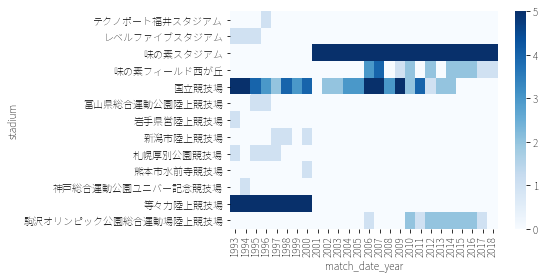

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
1588,1998,横浜F,鹿児島県立鴨池陸上競技場,12584.0,NaN,12584.0,32,1
733,1995,横浜F,熊本市水前寺競技場,15000.0,15000.0,15000.0,42,1
1610,1998,横浜F,ニッパツ三ツ沢球技場,15440.0,15046.0,15440.0,520,1
1124,1997,横浜F,富山県総合運動公園陸上競技場,18588.0,28494.0,18588.0,136,1
692,1995,横浜F,トランスコスモススタジアム長崎,20258.0,20246.0,20258.0,137,1
1295,1997,横浜F,国立競技場,54224.0,NaN,54224.0,288,1
1596,1998,横浜F,日産スタジアム,72081.0,72327.0,72081.0,301,1


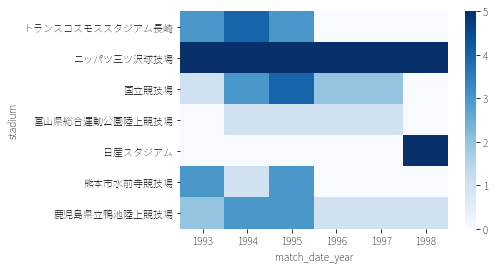

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
135,1993,広島,びんご運動公園陸上競技場,9245.0,9245.0,NaN,1,1
381,1994,広島,福山市竹ケ端運動公園陸上競技場,10081.0,10081.0,NaN,1,1
966,1996,広島,とりぎんバードスタジアム,11999.0,16033.0,11999.0,75,1
998,1996,広島,鹿児島県立鴨池陸上競技場,12584.0,NaN,12584.0,32,1
8522,2003,広島,コカ・コーラウエスト広島スタジアム,13800.0,13800.0,13800.0,67,1
527,1995,広島,大分市営陸上競技場,16000.0,16000.0,NaN,58,1
1125,1997,広島,ニンジニアスタジアム,20919.0,20000.0,20919.0,286,1
250,1994,広島,レベルファイブスタジアム,22331.0,22563.0,22331.0,448,1
10007,2008,広島,エディオンスタジアム広島,36894.0,NaN,36894.0,372,1
7339,2018,広島,,NaN,NaN,NaN,0,1


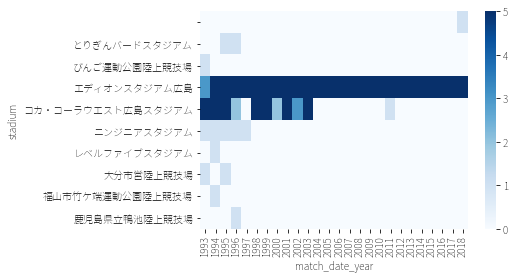

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
875,1996,鹿島,秋田市営八橋陸上競技場,0.0,NaN,NaN,5,1
1924,2000,鹿島,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
2082,2000,鹿島,とりぎんバードスタジアム,11999.0,16033.0,11999.0,75,1
1909,2000,鹿島,富山県総合運動公園陸上競技場,18588.0,28494.0,18588.0,136,1
1659,1999,鹿島,石川県西部緑地公園陸上競技場,20261.0,20000.0,20261.0,100,1
7313,2018,鹿島,県立カシマサッカースタジアム,37496.0,40728.0,37496.0,415,1
4914,2011,鹿島,国立競技場,54224.0,NaN,54224.0,288,1
7342,2018,鹿島,,NaN,NaN,NaN,0,1


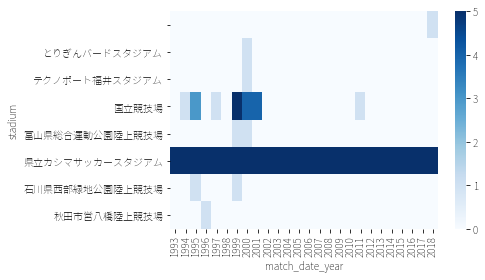

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
2936,2004,G大阪,シティライトスタジアム,15479.0,20000.0,15479.0,205,1
729,1995,G大阪,佐賀県総合運動場陸上競技場,17000.0,17000.0,17000.0,23,1
4736,2010,G大阪,石川県西部緑地公園陸上競技場,20261.0,20000.0,20261.0,100,1
553,1995,G大阪,京都市西京極総合運動公園陸上競技場兼球技場,20588.0,20588.0,20588.0,409,1
12093,2013,G大阪,万博記念競技場,21000.0,21000.0,21000.0,370,1
756,1995,G大阪,神戸総合運動公園ユニバー記念競技場,35910.0,35910.0,35910.0,139,1
7331,2018,G大阪,パナソニックスタジアム吹田,39694.0,39694.0,39694.0,50,1
7337,2018,G大阪,,NaN,NaN,NaN,0,1


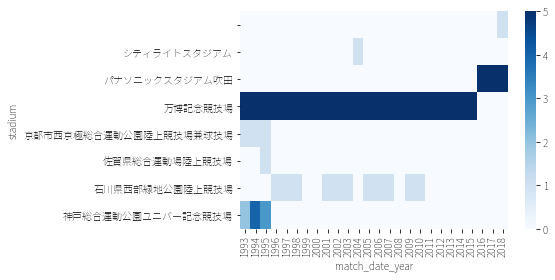

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
324,1994,清水,札幌厚別公園競技場,19620.0,20861.0,19620.0,183,1
13485,2016,清水,IAIスタジアム日本平,20248.0,20339.0,20248.0,388,1
909,1996,清水,トランスコスモススタジアム長崎,20258.0,20246.0,20258.0,137,1
750,1995,清水,石川県西部緑地公園陸上競技場,20261.0,20000.0,20261.0,100,1
222,1994,清水,ニンジニアスタジアム,20919.0,20000.0,20919.0,286,1
368,1994,清水,レベルファイブスタジアム,22331.0,22563.0,22331.0,448,1
2745,2003,清水,草薙総合運動公園陸上競技場,28000.0,28000.0,NaN,25,1
1006,1996,清水,神戸総合運動公園ユニバー記念競技場,35910.0,35910.0,35910.0,139,1
6370,2015,清水,エコパスタジアム,51697.0,50889.0,51697.0,63,1
3572,2006,清水,国立競技場,54224.0,NaN,54224.0,288,1


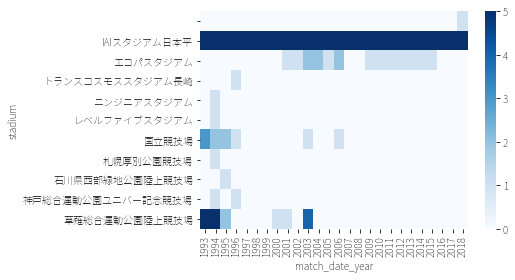

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
623,1995,浦和,NACK5スタジアム大宮,15491.0,15500.0,15491.0,317,1
442,1994,浦和,富山県総合運動公園陸上競技場,18588.0,28494.0,18588.0,136,1
557,1995,浦和,新潟市陸上競技場,18671.0,18671.0,NaN,75,1
968,1996,浦和,札幌厚別公園競技場,19620.0,20861.0,19620.0,183,1
7747,2000,浦和,浦和駒場スタジアム,21500.0,NaN,21500.0,177,1
385,1994,浦和,レベルファイブスタジアム,22331.0,22563.0,22331.0,448,1
416,1994,浦和,神戸総合運動公園ユニバー記念競技場,35910.0,35910.0,35910.0,139,1
2412,2002,浦和,国立競技場,54224.0,NaN,54224.0,288,1
7319,2018,浦和,埼玉スタジアム2002,62010.0,63700.0,62010.0,274,1
7343,2018,浦和,,NaN,NaN,NaN,0,1


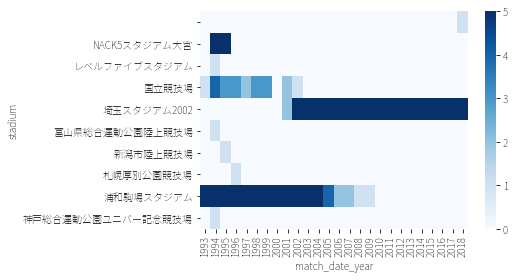

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
7287,2018,横浜FM,ニッパツ三ツ沢球技場,15440.0,15046.0,15440.0,520,1
303,1994,横浜FM,ShonanBMWスタジアム平塚,15732.0,15200.0,15732.0,490,1
294,1994,横浜FM,栃木県立グリーンスタジアム,18025.0,18025.0,NaN,12,1
1779,1999,横浜FM,新潟市陸上競技場,18671.0,18671.0,NaN,75,1
605,1995,横浜FM,札幌厚別公園競技場,19620.0,20861.0,19620.0,183,1
958,1996,横浜FM,トランスコスモススタジアム長崎,20258.0,20246.0,20258.0,137,1
1444,1998,横浜FM,NDソフトスタジアム山形,20784.0,20315.0,20784.0,402,1
340,1994,横浜FM,レベルファイブスタジアム,22331.0,22563.0,22331.0,448,1
2449,2002,横浜FM,えがお健康スタジアム,30684.0,32000.0,30684.0,204,1
4210,2008,横浜FM,国立競技場,54224.0,NaN,54224.0,288,1


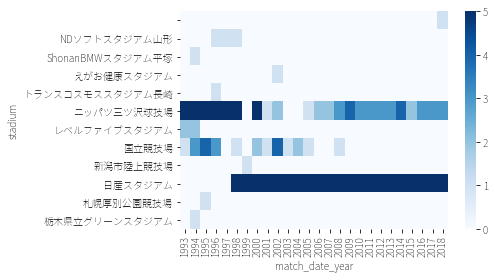

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
1276,1997,千葉,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
2138,2001,千葉,秋田市営八橋陸上競技場,0.0,NaN,NaN,5,1
145,1993,千葉,宮城陸上競技場,7000.0,7000.0,NaN,1,1
3286,2005,千葉,市原臨海競技場,14051.0,14051.0,NaN,165,1
366,1994,千葉,栃木県立グリーンスタジアム,18025.0,18025.0,NaN,12,1
383,1994,千葉,富山県総合運動公園陸上競技場,18588.0,28494.0,18588.0,136,1
1145,1997,千葉,新潟市陸上競技場,18671.0,18671.0,NaN,75,1
14414,2018,千葉,フクダ電子アリーナ,19470.0,19781.0,19470.0,257,1
626,1995,千葉,札幌厚別公園競技場,19620.0,20861.0,19620.0,183,1
1928,2000,千葉,ユアテックスタジアム仙台,19694.0,19694.0,19694.0,361,1


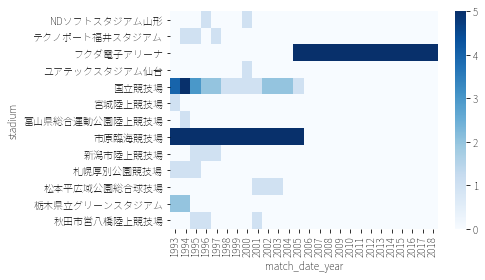

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
107,1993,名古屋,三重県営鈴鹿スポーツガーデン,0.0,NaN,NaN,3,1
258,1994,名古屋,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
1708,1999,名古屋,岐阜メモリアルセンター長良川競技場,16300.0,26109.0,16300.0,235,1
311,1994,名古屋,名古屋市港サッカー場,20000.0,20000.0,NaN,1,1
13927,2017,名古屋,パロマ瑞穂スタジアム,20223.0,27000.0,20223.0,286,1
122,1993,名古屋,レベルファイブスタジアム,22331.0,22563.0,22331.0,448,1
298,1994,名古屋,神戸総合運動公園ユニバー記念競技場,35910.0,35910.0,35910.0,139,1
13943,2017,名古屋,豊田スタジアム,41255.0,45000.0,41255.0,123,1
552,1995,名古屋,国立競技場,54224.0,NaN,54224.0,288,1
7347,2018,名古屋,,NaN,NaN,NaN,0,1


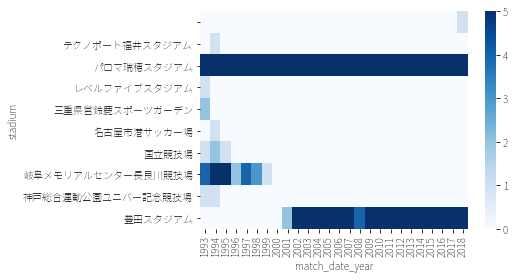

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
570,1995,磐田,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
13020,2015,磐田,ヤマハスタジアム(磐田),15165.0,15165.0,15165.0,381,1
198,1994,磐田,草薙総合運動公園陸上競技場,28000.0,28000.0,NaN,25,1
7090,2018,磐田,エコパスタジアム,51697.0,50889.0,51697.0,63,1
710,1995,磐田,国立競技場,54224.0,NaN,54224.0,288,1
7336,2018,磐田,,NaN,NaN,NaN,0,1


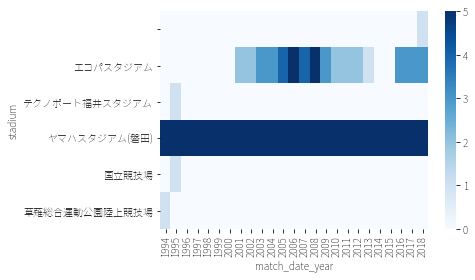

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
13959,2017,湘南,ShonanBMWスタジアム平塚,15732.0,15200.0,15732.0,490,1
926,1996,湘南,新潟市陸上競技場,18671.0,18671.0,NaN,75,1
592,1995,湘南,ニンジニアスタジアム,20919.0,20000.0,20919.0,286,1
1666,1999,湘南,国立競技場,54224.0,NaN,54224.0,288,1
7334,2018,湘南,,NaN,NaN,NaN,0,1


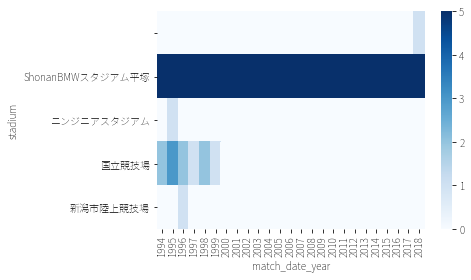

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
10792,2010,柏,三協フロンテア柏スタジアム,15109.0,15349.0,15109.0,349,1
947,1996,柏,新潟市陸上競技場,18671.0,18671.0,NaN,75,1
9331,2006,柏,柏の葉公園総合競技場,20000.0,20000.0,20000.0,31,1
5656,2013,柏,国立競技場,54224.0,NaN,54224.0,288,1
7344,2018,柏,,NaN,NaN,NaN,0,1


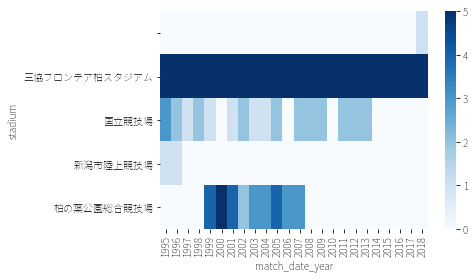

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
8147,2002,C大阪,三重県営鈴鹿スポーツガーデン,0.0,NaN,NaN,3,1
9568,2007,C大阪,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
9585,2007,C大阪,とりぎんバードスタジアム,11999.0,16033.0,11999.0,75,1
8096,2002,C大阪,大津市皇子山総合運動公園陸上競技場,15000.0,15000.0,NaN,2,1
1301,1997,C大阪,大分市営陸上競技場,16000.0,16000.0,NaN,58,1
13489,2016,C大阪,キンチョウスタジアム,17892.0,19904.0,17892.0,152,1
9605,2007,C大阪,三木総合防災公園陸上競技場,20000.0,20000.0,NaN,2,1
748,1995,C大阪,京都市西京極総合運動公園陸上競技場兼球技場,20588.0,20588.0,20588.0,409,1
878,1996,C大阪,ニンジニアスタジアム,20919.0,20000.0,20919.0,286,1
1711,1999,C大阪,近鉄花園ラグビー場,30000.0,30000.0,NaN,1,1


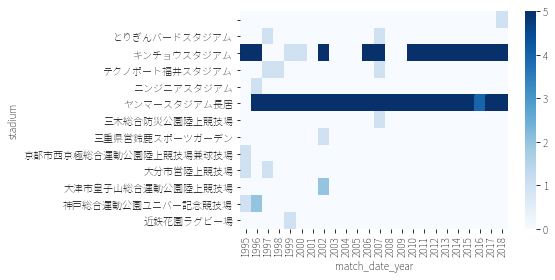

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
8755,2004,福岡,北九州市立本城陸上競技場,10000.0,10000.0,NaN,144,1
1390,1998,福岡,熊本市水前寺競技場,15000.0,15000.0,15000.0,42,1
9633,2007,福岡,トランスコスモススタジアム長崎,20258.0,20246.0,20258.0,137,1
14408,2018,福岡,レベルファイブスタジアム,22331.0,22563.0,22331.0,448,1


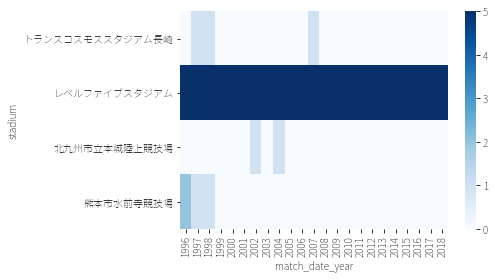

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
9508,2007,京都,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
7836,2001,京都,とりぎんバードスタジアム,11999.0,16033.0,11999.0,75,1
12250,2014,京都,鹿児島県立鴨池陸上競技場,12584.0,NaN,12584.0,32,1
1375,1998,京都,富山県総合運動公園陸上競技場,18588.0,28494.0,18588.0,136,1
1118,1997,京都,石川県西部緑地公園陸上競技場,20261.0,20000.0,20261.0,100,1
14404,2018,京都,京都市西京極総合運動公園陸上競技場兼球技場,20588.0,20588.0,20588.0,409,1
8668,2004,京都,高知県立春野総合運動公園陸上競技場,25000.0,25000.0,NaN,6,1


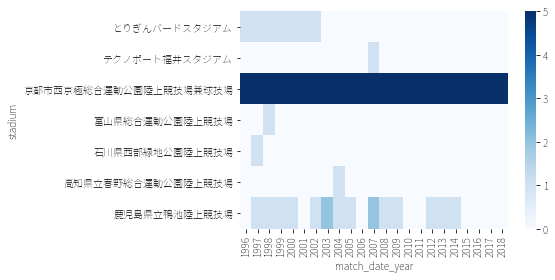

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
2545,2002,神戸,とりぎんバードスタジアム,11999.0,16033.0,11999.0,75,1
3228,2005,神戸,シティライトスタジアム,15479.0,20000.0,15479.0,205,1
2506,2002,神戸,鳴門・大塚スポーツパークポカリスエットスタジアム,17924.0,17924.0,17924.0,295,1
9305,2006,神戸,三木総合防災公園陸上競技場,20000.0,20000.0,NaN,2,1
12113,2013,神戸,ノエビアスタジアム神戸,28425.0,30132.0,28425.0,247,1
12023,2013,神戸,神戸総合運動公園ユニバー記念競技場,35910.0,35910.0,35910.0,139,1
7348,2018,神戸,,NaN,NaN,NaN,0,1


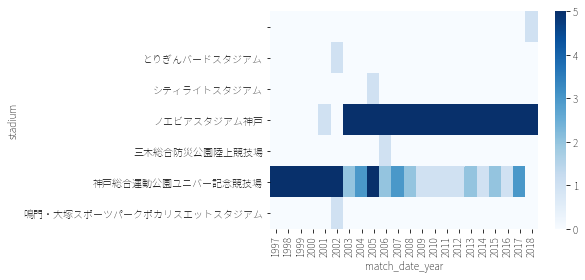

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
9426,2007,札幌,味の素フィールド西が丘,7258.0,7137.0,7258.0,41,1
10900,2011,札幌,室蘭市入江運動公園陸上競技場,12600.0,12600.0,NaN,21,1
13253,2016,札幌,函館市千代台公園陸上競技場,15000.0,15000.0,NaN,12,1
13412,2016,札幌,札幌厚別公園競技場,19620.0,20861.0,19620.0,183,1
1366,1998,札幌,ユアテックスタジアム仙台,19694.0,19694.0,19694.0,361,1
2354,2002,札幌,高知県立春野総合運動公園陸上競技場,25000.0,25000.0,NaN,6,1
13490,2016,札幌,札幌ドーム,39856.0,NaN,39856.0,202,1
7341,2018,札幌,,NaN,NaN,NaN,0,1


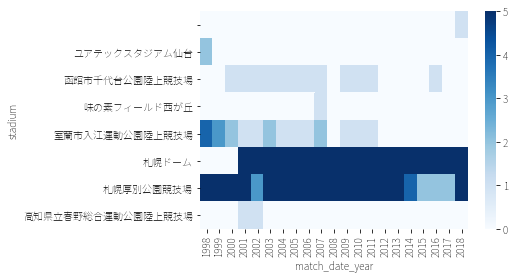

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
7502,1999,FC東京,江戸川区陸上競技場,6950.0,6950.0,NaN,9,1
7499,1999,FC東京,味の素フィールド西が丘,7258.0,7137.0,7258.0,41,1
1929,2000,FC東京,鹿児島県立鴨池陸上競技場,12584.0,NaN,12584.0,32,1
11037,2011,FC東京,熊谷スポーツ文化公園陸上競技場,15002.0,15392.0,15002.0,27,1
10899,2011,FC東京,駒沢オリンピック公園総合運動場陸上競技場,20010.0,20010.0,20010.0,23,1
2042,2000,FC東京,石川県西部緑地公園陸上競技場,20261.0,20000.0,20261.0,100,1
3489,2006,FC東京,松本平広域公園総合球技場,20336.0,20000.0,20336.0,154,1
2162,2001,FC東京,Pikaraスタジアム,22338.0,30099.0,22338.0,108,1
11172,2011,FC東京,味の素スタジアム,48999.0,49970.0,48999.0,541,1
11125,2011,FC東京,国立競技場,54224.0,NaN,54224.0,288,1


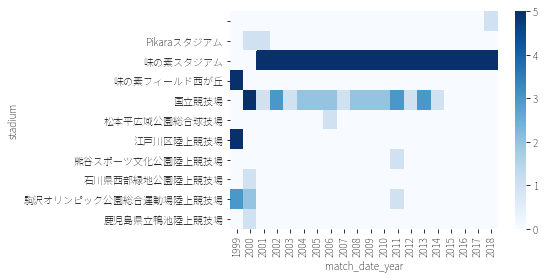

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
7966,2001,川崎F,長野運動公園総合運動場,0.0,NaN,NaN,2,1
7978,2001,川崎F,江戸川区陸上競技場,6950.0,6950.0,NaN,9,1
7991,2001,川崎F,味の素フィールド西が丘,7258.0,7137.0,7258.0,41,1
8002,2001,川崎F,町田市立陸上競技場,10328.0,10622.0,10328.0,84,1
8794,2004,川崎F,等々力陸上競技場,26827.0,26232.0,26827.0,448,1
5529,2013,川崎F,国立競技場,54224.0,NaN,54224.0,288,1
7440,1999,川崎F,日産スタジアム,72081.0,72327.0,72081.0,301,1
7345,2018,川崎F,,NaN,NaN,NaN,0,1


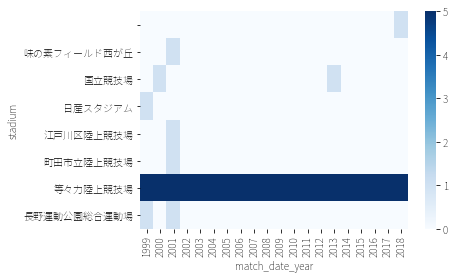

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
10463,2009,仙台,ユアテックスタジアム仙台,19694.0,19694.0,19694.0,361,1
10154,2009,仙台,福島県営あづま陸上競技場,21000.0,21000.0,NaN,3,1
10216,2009,仙台,宮城スタジアム,49133.0,49133.0,49133.0,22,1
7332,2018,仙台,,NaN,NaN,NaN,0,1


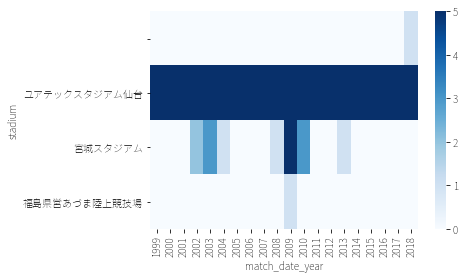

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
7609,2000,大分,佐伯市営陸上競技場,5000.0,5000.0,NaN,5,1
10684,2010,大分,鹿児島県立鴨池陸上競技場,12584.0,NaN,12584.0,32,1
7692,2000,大分,熊本市水前寺競技場,15000.0,15000.0,15000.0,42,1
8251,2002,大分,大分市営陸上競技場,16000.0,16000.0,NaN,58,1
8101,2002,大分,トランスコスモススタジアム長崎,20258.0,20246.0,20258.0,137,1
8115,2002,大分,えがお健康スタジアム,30684.0,32000.0,30684.0,204,1
14402,2018,大分,大分銀行ドーム,31997.0,40000.0,31997.0,285,1


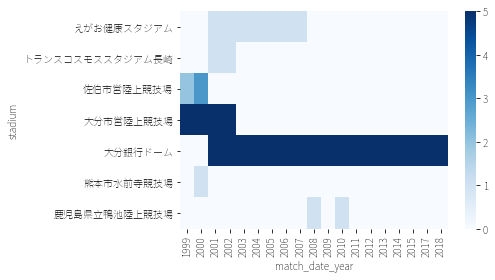

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
8463,2003,新潟,新潟市陸上競技場,18671.0,18671.0,NaN,75,1
6125,2014,新潟,県立カシマサッカースタジアム,37496.0,40728.0,37496.0,415,1
14415,2018,新潟,デンカビッグスワンスタジアム,41684.0,42300.0,41684.0,295,1
3041,2004,新潟,国立競技場,54224.0,NaN,54224.0,288,1


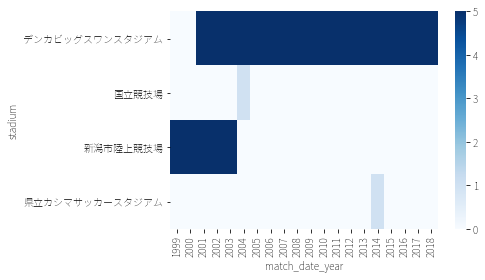

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
7885,2001,大宮,鴻巣市立陸上競技場,5000.0,5000.0,NaN,3,1
7708,2000,大宮,味の素フィールド西が丘,7258.0,7137.0,7258.0,41,1
14311,2018,大宮,熊谷スポーツ文化公園陸上競技場,15002.0,15392.0,15002.0,27,1
14405,2018,大宮,NACK5スタジアム大宮,15491.0,15500.0,15491.0,317,1
7496,1999,大宮,栃木県立グリーンスタジアム,18025.0,18025.0,NaN,12,1
8201,2002,大宮,浦和駒場スタジアム,21500.0,NaN,21500.0,177,1
8677,2004,大宮,埼玉スタジアム2002,62010.0,63700.0,62010.0,274,1


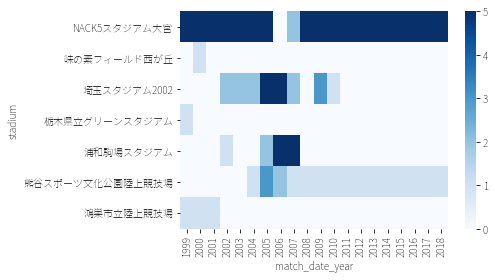

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
7705,2000,甲府,都市公園富士北麓公園陸上競技場,0.0,NaN,NaN,2,1
7564,2000,甲府,韮崎中央公園陸上競技場,4000.0,4000.0,NaN,5,1
14421,2018,甲府,山梨中銀スタジアム,15859.0,17000.0,15859.0,375,1
8866,2005,甲府,松本平広域公園総合球技場,20336.0,20000.0,20336.0,154,1
5924,2014,甲府,国立競技場,54224.0,NaN,54224.0,288,1


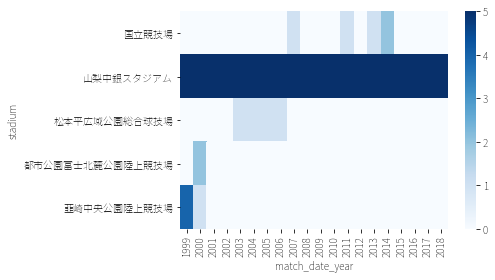

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
7948,2001,横浜FC,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
8753,2004,横浜FC,江東区夢の島競技場,2429.0,5050.0,2429.0,7,1
8189,2002,横浜FC,横浜市三ツ沢公園陸上競技場,5425.0,18300.0,5425.0,6,1
9000,2005,横浜FC,江戸川区陸上競技場,6950.0,6950.0,NaN,9,1
12988,2015,横浜FC,味の素フィールド西が丘,7258.0,7137.0,7258.0,41,1
14403,2018,横浜FC,ニッパツ三ツ沢球技場,15440.0,15046.0,15440.0,520,1
10443,2009,横浜FC,駒沢オリンピック公園総合運動場陸上競技場,20010.0,20010.0,20010.0,23,1
11567,2012,横浜FC,福島県営あづま陸上競技場,21000.0,21000.0,NaN,3,1
13906,2017,横浜FC,等々力陸上競技場,26827.0,26232.0,26827.0,448,1
11087,2011,横浜FC,国立競技場,54224.0,NaN,54224.0,288,1


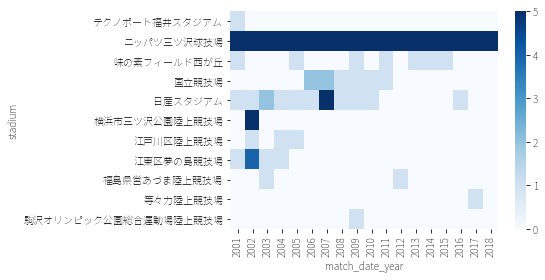

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
8649,2004,山形,秋田市営八橋陸上競技場,0.0,NaN,NaN,5,1
8843,2005,山形,Jヴィレッジスタジアム,0.0,NaN,NaN,1,1
7992,2001,山形,鶴岡市小真木原陸上競技場,7000.0,7000.0,NaN,6,1
7918,2001,山形,山形市陸上競技場,9000.0,9000.0,NaN,6,1
14417,2018,山形,NDソフトスタジアム山形,20784.0,20315.0,20784.0,402,1


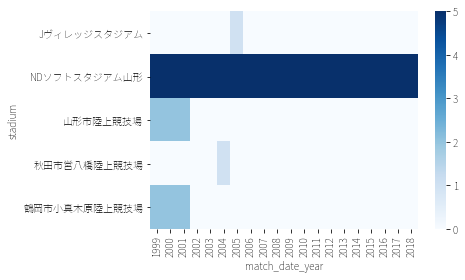

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
10736,2010,鳥栖,佐賀県総合運動場陸上競技場,17000.0,17000.0,17000.0,23,1
7898,2001,鳥栖,トランスコスモススタジアム長崎,20258.0,20246.0,20258.0,137,1
11183,2011,鳥栖,ベストアメニティスタジアム,24130.0,24130.0,24130.0,375,1
7971,2001,鳥栖,沖縄県総合運動公園陸上競技場,25000.0,25000.0,NaN,1,1
7340,2018,鳥栖,,NaN,NaN,NaN,0,1


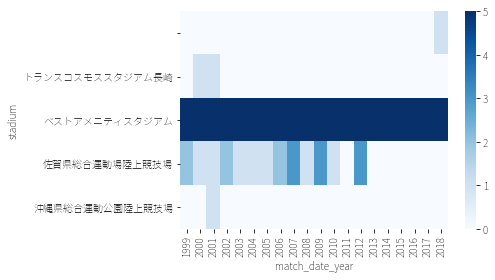

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
14411,2018,徳島,鳴門・大塚スポーツパークポカリスエットスタジアム,17924.0,17924.0,17924.0,295,1
9632,2007,徳島,Pikaraスタジアム,22338.0,30099.0,22338.0,108,1
9355,2006,徳島,高知県立春野総合運動公園陸上競技場,25000.0,25000.0,NaN,6,1


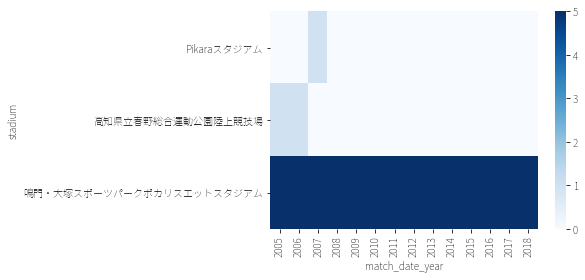

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
14003,2018,松本,山梨中銀スタジアム,15859.0,17000.0,15859.0,375,1
14418,2018,松本,松本平広域公園総合球技場,20336.0,20000.0,20336.0,154,1


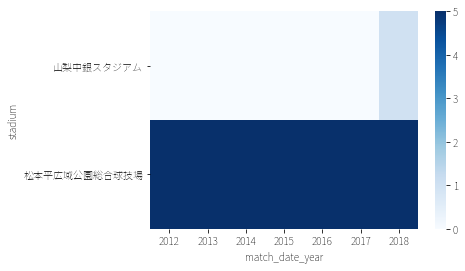

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
12528,2014,長崎,長崎市総合運動公園かきどまり陸上競技場,16000.0,5770.0,16000.0,3,1
13946,2017,長崎,トランスコスモススタジアム長崎,20258.0,20246.0,20258.0,137,1
7349,2018,長崎,,NaN,NaN,NaN,0,1


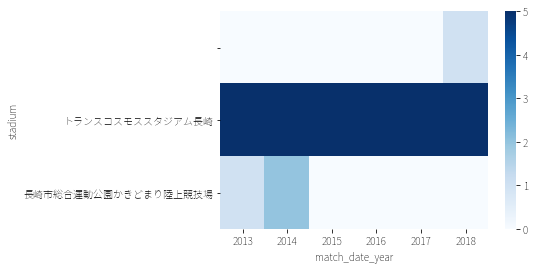

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
10203,2009,水戸,ひたちなか市総合運動公園陸上競技場,0.0,NaN,NaN,42,1
9671,2007,水戸,足利市総合運動公園陸上競技場,7500.0,7500.0,NaN,3,1
9946,2008,水戸,日立市民運動公園陸上競技場,8464.0,8464.0,NaN,11,1
14409,2018,水戸,ケーズデンキスタジアム水戸,10152.0,12000.0,10152.0,193,1
8560,2004,水戸,栃木県立グリーンスタジアム,18025.0,18025.0,NaN,12,1
12697,2015,水戸,笠松運動公園陸上競技場,22002.0,22002.0,NaN,155,1


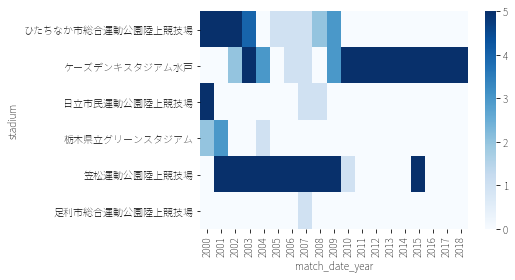

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
8909,2005,群馬,群馬県立敷島公園県営サッカー・ラグビー場,0.0,NaN,NaN,10,1
9046,2005,群馬,足利市総合運動公園陸上競技場,7500.0,7500.0,NaN,3,1
12395,2014,群馬,熊谷スポーツ文化公園陸上競技場,15002.0,15392.0,15002.0,27,1
13961,2017,群馬,正田醤油スタジアム群馬,15190.0,15253.0,15190.0,258,1
10342,2009,群馬,松本平広域公園総合球技場,20336.0,20000.0,20336.0,154,1


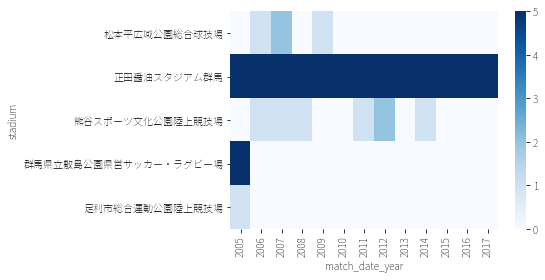

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
14412,2018,愛媛,ニンジニアスタジアム,20919.0,20000.0,20919.0,286,1
10296,2009,愛媛,高知県立春野総合運動公園陸上競技場,25000.0,25000.0,NaN,6,1


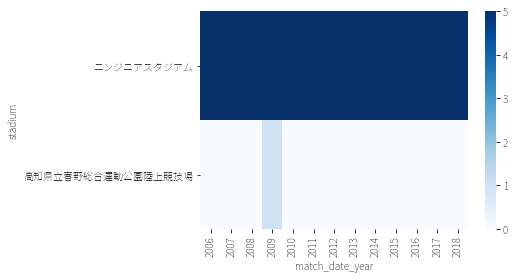

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
9891,2008,熊本,鹿児島県立鴨池陸上競技場,12584.0,NaN,12584.0,32,1
14150,2018,熊本,熊本市水前寺競技場,15000.0,15000.0,15000.0,42,1
13181,2016,熊本,三協フロンテア柏スタジアム,15109.0,15349.0,15109.0,349,1
13235,2016,熊本,ベストアメニティスタジアム,24130.0,24130.0,24130.0,375,1
13194,2016,熊本,ノエビアスタジアム神戸,28425.0,30132.0,28425.0,247,1
14413,2018,熊本,えがお健康スタジアム,30684.0,32000.0,30684.0,204,1


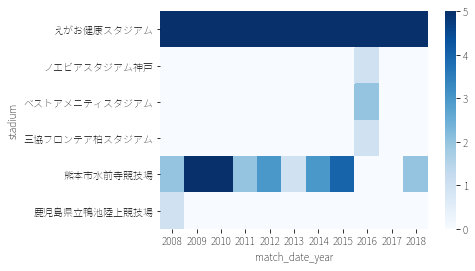

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
11604,2012,岐阜,岐阜メモリアルセンター長良川球技メドウ,0.0,NaN,NaN,19,1
12018,2013,岐阜,大垣市浅中公園総合グラウンド陸上競技場,4300.0,4300.0,NaN,1,1
14422,2018,岐阜,岐阜メモリアルセンター長良川競技場,16300.0,26109.0,16300.0,235,1


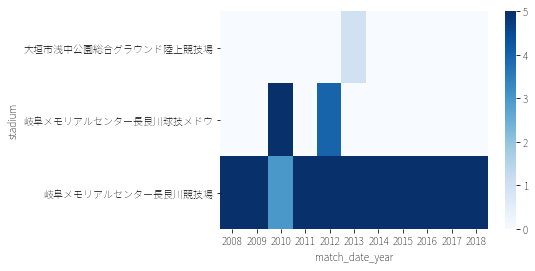

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
10072,2009,栃木,味の素フィールド西が丘,7258.0,7137.0,7258.0,41,1
10388,2009,栃木,足利市総合運動公園陸上競技場,7500.0,7500.0,NaN,3,1
10171,2009,栃木,熊谷スポーツ文化公園陸上競技場,15002.0,15392.0,15002.0,27,1
14410,2018,栃木,栃木県グリーンスタジアム,15325.0,18025.0,15325.0,163,1
10036,2009,栃木,国立競技場,54224.0,NaN,54224.0,288,1


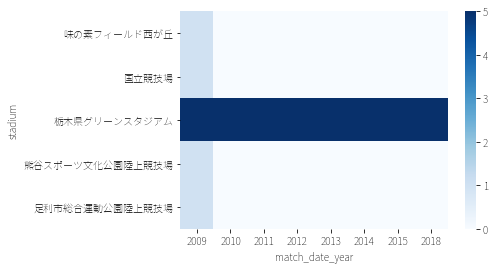

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
12950,2015,岡山,岡山県津山陸上競技場,10000.0,10000.0,10000.0,5,1
10398,2009,岡山,とりぎんバードスタジアム,11999.0,16033.0,11999.0,75,1
14420,2018,岡山,シティライトスタジアム,15479.0,20000.0,15479.0,205,1


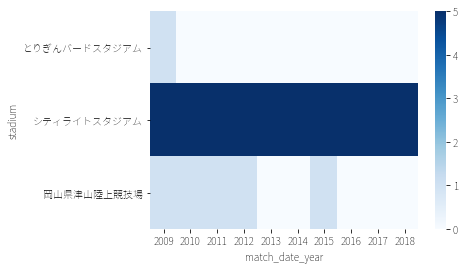

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
12573,2014,富山,富山県総合運動公園陸上競技場,18588.0,28494.0,18588.0,136,1


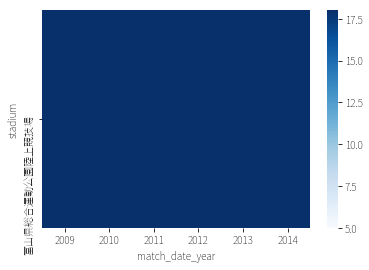

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
13483,2016,北九州,北九州市立本城陸上競技場,10000.0,10000.0,NaN,144,1


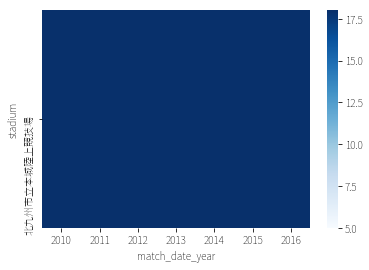

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
12110,2013,鳥取,とりぎんバードスタジアム,11999.0,16033.0,11999.0,75,1


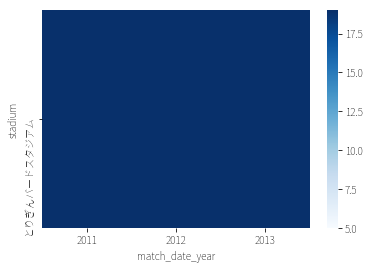

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
14416,2018,町田,町田市立陸上競技場,10328.0,10622.0,10328.0,84,1
11205,2012,町田,駒沢オリンピック公園総合運動場陸上競技場,20010.0,20010.0,20010.0,23,1


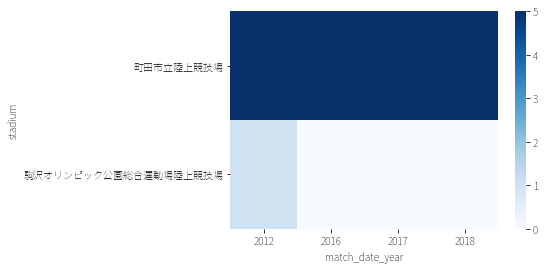

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
14423,2018,讃岐,Pikaraスタジアム,22338.0,30099.0,22338.0,108,1


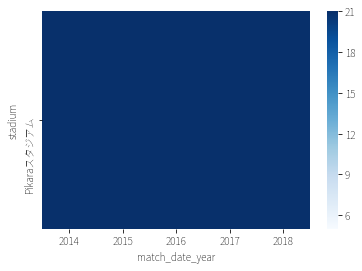

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
14419,2018,金沢,石川県西部緑地公園陸上競技場,20261.0,20000.0,20261.0,100,1


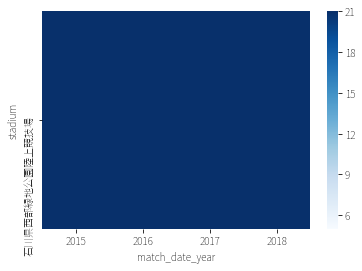

,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
14351,2018,山口,下関市営下関陸上競技場,9430.0,23939.0,9430.0,5,1
14407,2018,山口,維新みらいふスタジアム,15115.0,20000.0,15115.0,58,1


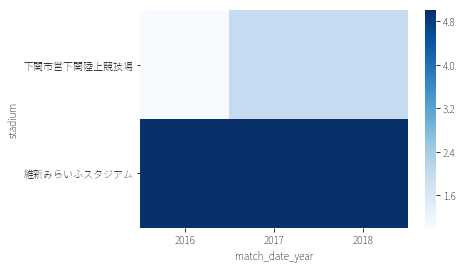

In [40]:
# ここで表記ゆれを確認する

for team in checker_df.home_team.unique():
    tmp = checker_df.query("home_team == '{}'".format(team))
    display(tmp.drop_duplicates("stadium", keep="last").sort_values("capacity"))
    sns.heatmap(
            tmp.pivot_table(columns="match_date_year",
                            index="stadium",
                            values="appear",
                            aggfunc="sum").fillna(0),
            cmap="Blues",
            vmax=5,
             )
    plt.show()

In [41]:
stadium_df[stadium_df.stadium.str.contains("等々力")]

,stadium,clean_capacity,dirty_capacity,capacity
27,等々力陸上競技場,26827.0,26232.0,26827.0
105,等々力緑地運動公園陸上競技場,NaN,NaN,0.0


,match_date_year,home_team,stadium,capacity,dirty_capacity,clean_capacity,total_appear,appear
10203,2009,水戸,ひたちなか市総合運動公園陸上競技場,0.0,NaN,NaN,42,1
8147,2002,C大阪,三重県営鈴鹿スポーツガーデン,0.0,NaN,NaN,3,1
7705,2000,甲府,都市公園富士北麓公園陸上競技場,0.0,NaN,NaN,2,1
11604,2012,岐阜,岐阜メモリアルセンター長良川球技メドウ,0.0,NaN,NaN,19,1
9568,2007,C大阪,テクノポート福井スタジアム,0.0,NaN,NaN,12,1
8649,2004,山形,秋田市営八橋陸上競技場,0.0,NaN,NaN,5,1
8909,2005,群馬,群馬県立敷島公園県営サッカー・ラグビー場,0.0,NaN,NaN,10,1
8843,2005,山形,Jヴィレッジスタジアム,0.0,NaN,NaN,1,1
7966,2001,川崎F,長野運動公園総合運動場,0.0,NaN,NaN,2,1
8753,2004,横浜FC,江東区夢の島競技場,2429.0,5050.0,2429.0,7,1


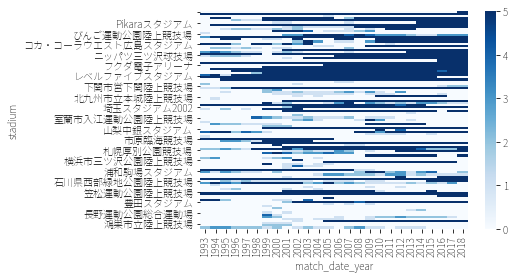

In [42]:
tmp = checker_df
display(tmp.drop_duplicates("stadium", keep="last").sort_values("capacity"))
sns.heatmap(
        tmp.pivot_table(columns="match_date_year",
                        index="stadium",
                        values="appear",
                        aggfunc="sum").fillna(0),
        cmap="Blues",
        vmax=5,
         )
plt.show()

In [43]:
handmaid_stadium = [["秋田市営八橋陸上競技場", 20125],
                    ["都市公園富士北麓公園陸上競技場", 10000],
                    #["長野運動公園総合運動場", 17350],
                    ["三重県営鈴鹿スポーツガーデン", 12000],
                    ["Jヴィレッジスタジアム", 5000],
                    ["群馬県立敷島公園県営サッカー・ラグビー場", 7800], # これは特例で芝生席が認められたであろう例(wikipedia)
                    ["長野運動公園総合運動場", 5200], # J2では芝生席を含んではいけないので
                    ["ひたちなか市総合運動公園陸上競技場", 15000],
                    ["岐阜メモリアルセンター長良川球技メドウ", 3560],
                    ["テクノポート福井スタジアム", 21053],
                    ["草薙総合運動公園陸上競技場", 16000] # 芝生席を除いた値
                   ]
my_stadium = pd.DataFrame(handmaid_stadium)
my_stadium.columns = ["stadium", "hand_capacity"]

stadium_df = stadium_df.merge(my_stadium,
                              on="stadium",
                              how="left")

In [44]:
stadium_df["capacity"] = (stadium_df["clean_capacity"].fillna(0) +\
                          stadium_df["hand_capacity"].fillna(0) * stadium_df["clean_capacity"].isna() +\
                          stadium_df["dirty_capacity"].fillna(0) * (stadium_df[["clean_capacity", "hand_capacity"]].isna().all(axis=1)))

In [47]:
stadium_df[stadium_df["capacity"] == 0]

,stadium,clean_capacity,dirty_capacity,capacity,hand_capacity
100,横浜市三ツ沢総合公園球技場,NaN,NaN,0.0,NaN
101,広島スタジアム,NaN,NaN,0.0,NaN
104,静岡県営草薙陸上競技場,NaN,NaN,0.0,NaN
105,等々力緑地運動公園陸上競技場,NaN,NaN,0.0,NaN
121,埼玉県営大宮公園サッカー場,NaN,NaN,0.0,NaN
131,七北田公園仙台スタジアム,NaN,NaN,0.0,NaN
141,神戸ウイングスタジアム,NaN,NaN,0.0,NaN
162,長野市営長野運動公園総合運動場,NaN,NaN,0.0,NaN


In [45]:
#stadium_df.to_csv("../ext_source/ex_modified_stadium2.csv", index=None)

In [ ]:
UFT.groups()